# Libraries

In [1]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd


from scipy import signal
from scipy.io import wavfile

# from pybv import write_brainvision
from pyprep.prep_pipeline import PrepPipeline
from mne_icalabel import label_components

# set working directory
work_dir = '/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/'
# pc
# work_dir = '/Users/hanch/OneDrive - University of Toronto/Projects/Yas accent/'


# Trigger lag fix

## parameters

In [2]:
# directory
input_dir = work_dir + 'data_raw/'
output_dir = work_dir + 'data_preprocessed/1_trigger_lag_fixed/'
# create a folder if the folder doesn't exist
os.makedirs(output_dir, exist_ok=True)

# create a dictionary for blocks and markers
block_dict = {
    'ChEn':1000, # standard: chinese; deviant: english
    'EnCh':2000, # standard: english; deviant: chinese
    'InEn':3000, # standard: indian; deviant: english
    'EnIn':4000, # standard: english, deviant: indian
}


# exclude participants with missing data
exclude_ppts = [
    '140', # no data
    '197', # no data
    
    '135', # incomplete data
    '179', # incomplete data
    '182', # incomplete data

    '141', # wrong experiment was run

    '261', # no StimTrak recording

    '271', # no stimtrak
    '272', # no stimtrak

    '115', # unknown
]

# trigger searching window (actual trigger time based on audio - trigger time in the data)
t_left = -0.01
t_right = 0.05

Extracting parameters from /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_raw/Yas_261.vhdr...
Setting channel info structure...
Reading 0 ... 1747174  =      0.000 ...  3494.348 secs...


ValueError: Could not find any of the events you specified.

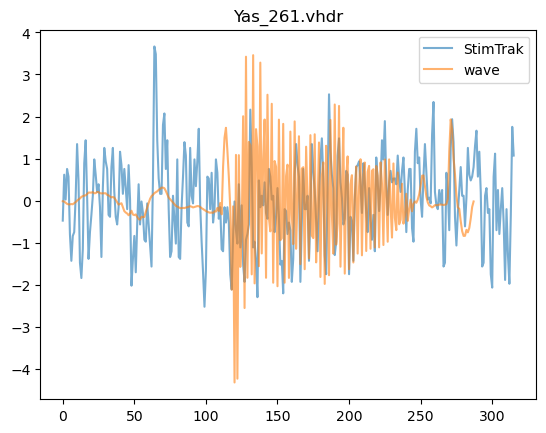

In [3]:
#######################################################
#### create a dictionary for trigger codes and descriptions ####
df = pd.read_csv("mapping.txt", delimiter='\t')
mapping = dict(zip(df['code'], df['description']))
#######################################################

#### create a trigger dictionary for each stim's standard version and deviant version ####

# intialize a dictionary for triggers
trigger_dict = {}

# read in trigger_codes file
with open('trigger_codes.txt','r') as tf:
    for line in tf:
        # read in the current line
        line = line.replace('\n','')
        # separate fileNames and triggerMarker
        label, marker = line.split('\t')
        # convert trigger markers to integer
        marker = int(marker)
        # create label for stims used as standards
        trigger_dict[marker] = label + '-s'
        # add 100 for deviant marker
        marker_deviant = marker + 100
        # create label for stims used as deviants
        trigger_dict[marker_deviant] = label + '-d'



#### trigger correction for each file ####

# initialize a dictionary to save bad stims
all_bad_stim_dict = {}

# read in eeg data files
all_files = os.listdir(input_dir)

#### for each file, create an all_block dictionary to store each block and the indices of trials of that block  ####
for file in all_files:
    if file.endswith(".vhdr") and (file.split('.')[0]+ '_corr.fif' not in os.listdir(output_dir)):

        # exclude bad data
        if (file.split('.')[0].split('_')[1] in exclude_ppts):
            continue
            
        # read in vhdr files
        raw = mne.io.read_raw_brainvision(input_dir + file, preload = True)

        # extract sampling rate
        eeg_sfreq = raw.info['sfreq']
        
        # If the aux channel is not named 'StimTrak', change the channel name to 'StimTrak'
        if raw.info['ch_names'][31] != 'StimTrak':
            # change the channel name
            raw.rename_channels({raw.info['ch_names'][31]: 'StimTrak'})
            # specify the audio channel
            raw.set_channel_types({'StimTrak':'misc'})

        ##########################################################################################
        #### get trigger code, audio data, create a trigger dictionary for each stim's standard version and deviant version ####

        # initialize dictionaries
        audio = {}
        lengths = {}
        
        # del trigger_dict[99999]
        for marker,label in trigger_dict.items():
            # extract file name
            file_name = label[:7]
            # if not already in audio dictionary, get the info of the audio file
            if file_name not in audio:
                # get sample rate and data of the audio file
                sampleRate, data = wavfile.read(work_dir + 'yas_exp/stimuli/{}.wav'.format(file_name))
                # calculate sound file length
                lengths[file_name] = len(data)/sampleRate
                # reduce the sampling rate of the audio file by the factor of int(sampleRate/eeg_freq)
                data_downsampled = signal.decimate(data,int(sampleRate/eeg_sfreq), ftype='fir')
                # add info the audio dictionary
                audio[file_name] = data_downsampled

        #### making events ####
        # for each stimulus, mark the block info
        events_from_annot, event_dict = mne.events_from_annotations(raw, verbose='WARNING')
        # remove useless markers (New Segment: 99999, pause: 222, and continue: 223)
        events_from_annot = events_from_annot[events_from_annot[:, 2] < 200]
                
        # initialize the train for each standards+deviant sequence
        train = np.array([]).astype(int)
        
        all_block = {}
        isStandard = True # whether the standard in a train has been noted
            
        # loop over each trigger
        for i in range(events_from_annot.shape[0]):
                
            # add the current token to the train
            train = np.append(train,i)

            # trigger code
            trigger_marker = events_from_annot[i,2]
            
            # if the trigger code is smaller than 100 and the standard note is true
            if (trigger_marker<100) & isStandard:
                # save the standard stim category
                block = trigger_dict[trigger_marker][:2]
                # toggle standard note
                standard = False

            # if the trigger value is over 100
            elif trigger_marker>100:
                # append the deviant stim category 
                block = block + trigger_dict[trigger_marker][:2]

                # if the block is not present in all block
                if block not in all_block:
                    # add the new block and the token idx
                    all_block[block] = train[2:] # [2:] to exclude the first 2 standards
                else:
                    # add the token idx to the existing block
                    all_block[block] = np.concatenate([ all_block[block], train[2:] ], axis=None)

                # reset train
                train = np.array([]).astype(int)

                # toggle standard note
                isStandard = True
        
        # loop over each block and its trigger index
        for k,v in all_block.items(): 
            # recode the trigger value to reflect block and stim category
            events_from_annot[tuple(v),2] += block_dict[k]

        # exclude the first 2 standards
        events_from_annot = events_from_annot[events_from_annot[:,2]>1000]
        ##########################################################################################
        
        ########################################################
        #### calculate cross correction to detect the delay ####
        
        # initialize delay list
        delays = np.array([])
        # initialize bad stim list
        bad_stim = []
        corr_results = []
        
        # loop over each event
        for i in range(events_from_annot.shape[0]):

            # get current event info [time, duration, annotation]
            event = events_from_annot[i]
            # get the onset latency (s) of the event
            time = event[0]/eeg_sfreq
            # get the file name of the event
            name = trigger_dict[event[2]%100].split('-')[0]
            # get the data from the sound channel
            audio_eeg = raw.get_data(
                picks = ['StimTrak'],
                tmin = time + t_left,
                tmax = time + lengths[name] + t_right,
            )[0]
            # actual stimulus
            audio_stim = audio[name]
            
            # Z-score normalization (subtract mean, divide by std)
            audio_eeg = (audio_eeg - np.mean(audio_eeg)) / np.std(audio_eeg)
            audio_stim = (audio_stim - np.mean(audio_stim)) / np.std(audio_stim)

            # cross-correlation
            corr = signal.correlate(audio_eeg, audio_stim, mode='full')
            # Normalize cross-correlation
            corr = corr / (np.linalg.norm(audio_eeg) * np.linalg.norm(audio_stim))
            # Find peak correlation value
            max_corr = np.max(corr)    
            
            # if the maximum correction (sum of products) is less than a threshold (empirical, but 0.5 is good for most cases)
            if max_corr < 0.5:
                # mark the stim bad
                bad_stim.append(i)
            
            # append the maximum correlation
            corr_results.append(max_corr)
            
            # the lags for cross-correlation
            lags = signal.correlation_lags(
                audio_eeg.size,
                audio_stim.size,
                mode="full")
            # get the lag of the maximum cross-correlation
            lag = lags[np.argmax(corr)] + t_left*eeg_sfreq
            
            # save the lag for non-starting events
            delays = np.append(delays, lag)
        ########################################################

        ##################################################################################################
        #### plot the wave from the stim track and the eeg channel of the token with the minimum corr ####
        
        min_corr = np.argmin(corr_results)
        # get current event info [time, duration, annotation]
        event = events_from_annot[min_corr]
        # get the onset latency (s) of the event
        time = event[0]/eeg_sfreq
        # get the file name of the event
        name = trigger_dict[event[2]%100].split('-')[0]
        # get the data from the sound channel
        audio_eeg = raw.get_data(
            picks = ['StimTrak'],
            tmin = time + t_left,
            tmax = time + lengths[name] + t_right,
        )[0]
        # actual stimulus
        audio_stim = audio[name]
        # Z-score normalization (subtract mean, divide by std)
        audio_eeg = (audio_eeg - np.mean(audio_eeg)) / np.std(audio_eeg)
        audio_stim = (audio_stim - np.mean(audio_stim)) / np.std(audio_stim)
        # plot
        fig, ax = plt.subplots()
        ax.plot(audio_eeg, label = 'StimTrak', alpha = 0.6)
        ax.plot(audio_stim, label = 'wave', alpha = 0.6)
        ax.set_title(file)
        ax.legend()
        fig.savefig(output_dir + file.split('.')[0] + "_minCor.png", dpi=300, bbox_inches='tight')
        ##################################################################################################

                
        ####################################################
        #### correct for trigger lag and save log files ####

        # add number of bad stim info
        all_bad_stim_dict[file] = len(bad_stim)

        # remove items associated with bad stims from the event list
        events_from_annot = np.delete(events_from_annot, bad_stim, 0)
        
        # remove items associated with bad stims from the delay list
        delays = np.delete(delays, bad_stim, 0)

        # add delay back to the onset latency of each event
        events_from_annot[:,0] = events_from_annot[:,0] + delays

        # # convert individual event marker to conditions
        # events_from_annot[:,2] = events_from_annot[:,2] - events_from_annot[:,2]%100

        # create annotations
        annot_from_events = mne.annotations_from_events(
            events = events_from_annot,
            event_desc = mapping,
            sfreq = raw.info['sfreq']
        )

        # set annotations
        raw.set_annotations(annot_from_events)
        
        # drop the audio channel in data
        raw.drop_channels(['StimTrak'])
        
        # save as a file-into-file data
        raw.save(output_dir + file.split('.')[0]+ '_corr.fif')
        
        # save lag data
        np.savetxt(output_dir + file.replace('.vhdr', '_delays.txt'), delays, fmt='%i')
        ####################################################
        

# save the number of bad stims of all participant
with open(output_dir + 'bad_stim.txt', 'a') as f:
    for key, value in all_bad_stim_dict.items():
        if value > 0:
            f.write(key + '\t' + str(value) + '\n')

In [6]:
events_from_annot

array([], shape=(0, 3), dtype=int64)

# Bad channel correction
- filtering
- resampling
- remove line noise
- bad channel detection & repairing
- add back reference channel TP9

## parameters

In [12]:
# set directory
input_dir = work_dir + 'data_preprocessed/1_trigger_lag_fixed/'
output_dir = work_dir + 'data_preprocessed/2_bad_channel_corrected/'
# create a folder if the folder doesn't exist
os.makedirs(output_dir, exist_ok=True)

# filter cutoff frequencies (low/high)
f_low = 1
f_high = 100

# resampling frequency
f_res = 250

# line frequency
line_freq = 60

# preprocessing parameters
prep_params = {
    "ref_chs": 'eeg',
    "reref_chs": 'eeg', # average re-reference
    "line_freqs": np.arange(line_freq, f_res/2, line_freq),
}

# create a montage file for the pipeline
montage = mne.channels.make_standard_montage("standard_1020")

# interpolation method
# method=dict(eeg="spline")

exclude_ppts = [
    '187', # too many bad stims
    '200', # too many bad stims
    '259', # too many bad stims
    '273', # too many bad stims
]

In [10]:
#####################################################
#### Preprocessing (filtering, resampling, bad channel detection/interpoloation, re-reference) ####
#####################################################

# get all file namesin the folder
all_input = os.listdir(input_dir)
all_output = os.listdir(output_dir)


for file in all_input:
    if file.endswith("corr.fif") and (file.split('_')[1] not in exclude_ppts) and (file.split('.')[0]+ '_prep.fif' not in all_output):
        
        # read in file
        raw = mne.io.read_raw_fif(input_dir + file, preload=True)
        
        # set channel type
        raw.set_channel_types({'Fp1':'eog', 'Fp2':'eog'})

        # filter
        raw.filter(l_freq = f_low, h_freq = f_high)
        
        #### cut off the beginning and ending part ####
        
        # get the onset of the first and the last event ####
        events_from_annot, event_dict = mne.events_from_annotations(raw, verbose='WARNING')

        # define the beginning time (in seconds)
        crop_start = events_from_annot[0][0]/raw.info['sfreq'] - 10

        # define the ending time (in seconds)
        crop_end = events_from_annot[-1][0]/raw.info['sfreq'] + 10

        # crop the data
        raw.crop(
            tmin=max(crop_start, raw.times[0]), 
            tmax=min(crop_end, raw.times[-1])
        )
        
        # resample
        raw.resample(sfreq = f_res)

        # read in channel location info
        raw.set_montage(montage)
        
        ####  Use PrePipeline to preprocess ####
        '''
        1. detect and interpolate bad channels
        2. remove line noise
        3. re-reference
        '''
        
        # apply pyprep
        prep = PrepPipeline(raw, prep_params, montage, random_state=42)
        prep.fit()

        
        # export a txt file for the interpolated channel info
        with open(output_dir + 'bad_channel.txt', 'a+') as f:
            _ =f.write(
                file + ':\n' +
                "- Bad channels original: {}".format(prep.noisy_channels_original["bad_all"]) + '\n' +
                "- Bad channels after robust average reference: {}".format(prep.interpolated_channels) + '\n' +
                "- Bad channels after interpolation: {}".format(prep.still_noisy_channels) + '\n'
            )

        # save the pypred preprocessed data into the raw data structure
        raw = prep.raw

        # spline interpolating remaining bad channels if any
        raw.interpolate_bads()

        # add back the reference channel
        raw = mne.add_reference_channels(raw,'TP9')

        # add the channel loc info (for the newly added reference channel)
        raw.set_montage(montage)
        
        # save
        raw.save(output_dir + file.split('.')[0]+ '_prep.fif')

Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_273_corr.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/1118127265.py:14: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_273_corr.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Isotrak not found
    Range : 0 ... 1788649 =      0.000 ...  3577.298 secs
Ready.
Reading 0 ... 1788649  =      0.000 ...  3577.298 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/1118127265.py:43: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Removed notch frequencies (Hz):
     60.00 : 19604 windows
    120.00 : 19604 windows
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/677 [00:00<?,       ?it/s]


RANSAC done!


2025-07-19 00:50:41,763 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['P7'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['P7']}


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/677 [00:00<?,       ?it/s]


RANSAC done!


2025-07-19 00:51:14,444 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['T8'], 'bad_by_correlation': ['T8'], 'bad_by_SNR': ['T8'], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['T8']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 1 sensors


2025-07-19 00:51:14,770 - pyprep.reference - INFO - Iterations: 1


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/677 [00:00<?,       ?it/s]


RANSAC done!


2025-07-19 00:51:45,399 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['T8'], 'bad_by_correlation': ['T8'], 'bad_by_SNR': ['T8'], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['T8']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 1 sensors


2025-07-19 00:51:45,761 - pyprep.reference - INFO - Iterations: 2


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/677 [00:00<?,       ?it/s]


RANSAC done!


2025-07-19 00:52:17,263 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['T8'], 'bad_by_correlation': ['T8'], 'bad_by_SNR': ['T8'], 'bad_by_dropout': [], 'bad_by_ransac': ['FT9'], 'bad_all': ['FT9', 'T8']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 27 sensor positions
Interpolating 2 sensors


2025-07-19 00:52:17,660 - pyprep.reference - INFO - Iterations: 3


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/677 [00:00<?,       ?it/s]


RANSAC done!


2025-07-19 00:52:48,836 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['T8'], 'bad_by_correlation': ['T8'], 'bad_by_SNR': ['T8'], 'bad_by_dropout': [], 'bad_by_ransac': ['FT9'], 'bad_all': ['FT9', 'T8']}
2025-07-19 00:52:48,837 - pyprep.reference - INFO - Robust reference done


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 27 sensor positions
Interpolating 2 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/677 [00:00<?,       ?it/s]


RANSAC done!
Found 1 uniquely bad channels:

0 by NaN: []

0 by flat: []

0 by deviation: []

1 by HF noise: ['T8']

1 by correlation: ['T8']

1 by SNR: ['T8']

0 by dropout: []

0 by RANSAC: []

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 1 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/677 [00:00<?,       ?it/s]


RANSAC done!
Setting channel interpolation method to {'eeg': 'spline'}.
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_273_corr_prep.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/1118127265.py:70: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads()
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/1118127265.py:73: RuntimeWarning: Location for this channel is unknown or ambiguous; consider calling set_montage() after adding new reference channels if needed. Applying a montage will only set locations of channels that exist at the time it is applied.
  raw = mne.add_reference_channels(raw,'TP9')
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/1118127265.py:76: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/1118127265.py:7

Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_273_corr_prep.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_274_corr.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/1118127265.py:14: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_274_corr.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Isotrak not found
    Range : 0 ... 2007299 =      0.000 ...  4014.598 secs
Ready.
Reading 0 ... 2007299  =      0.000 ...  4014.598 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/1118127265.py:43: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Removed notch frequencies (Hz):
     60.00 : 22968 windows
    120.00 : 22968 windows
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/793 [00:00<?,       ?it/s]


RANSAC done!


2025-07-19 00:54:56,806 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['FT9', 'T7'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['FT9', 'T7']}


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/793 [00:00<?,       ?it/s]


RANSAC done!


2025-07-19 00:55:37,998 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['FT9'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['T7'], 'bad_all': ['FT9', 'T7']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 27 sensor positions
Interpolating 2 sensors


2025-07-19 00:55:38,747 - pyprep.reference - INFO - Iterations: 1


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/793 [00:00<?,       ?it/s]


RANSAC done!


2025-07-19 00:56:17,947 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['FT9', 'T7'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['T7'], 'bad_all': ['FT9', 'T7']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 27 sensor positions
Interpolating 2 sensors


2025-07-19 00:56:18,522 - pyprep.reference - INFO - Iterations: 2


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/793 [00:00<?,       ?it/s]


RANSAC done!


2025-07-19 00:56:56,767 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['FT9', 'T7'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['T7'], 'bad_all': ['FT9', 'T7']}
2025-07-19 00:56:56,767 - pyprep.reference - INFO - Robust reference done


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 27 sensor positions
Interpolating 2 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/793 [00:00<?,       ?it/s]


RANSAC done!
Found 2 uniquely bad channels:

0 by NaN: []

0 by flat: []

0 by deviation: []

0 by HF noise: []

2 by correlation: ['FT9', 'T7']

0 by SNR: []

0 by dropout: []

0 by RANSAC: []

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 27 sensor positions
Interpolating 2 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/793 [00:00<?,       ?it/s]


RANSAC done!
Setting channel interpolation method to {'eeg': 'spline'}.
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_274_corr_prep.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/1118127265.py:70: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads()
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/1118127265.py:73: RuntimeWarning: Location for this channel is unknown or ambiguous; consider calling set_montage() after adding new reference channels if needed. Applying a montage will only set locations of channels that exist at the time it is applied.
  raw = mne.add_reference_channels(raw,'TP9')
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/1118127265.py:76: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/1118127265.py:7

Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_274_corr_prep.fif
[done]


# ICA bad trial correction

## parameters

In [14]:
# directory
input_dir = work_dir + 'data_preprocessed/2_bad_channel_corrected/'
output_dir = work_dir + 'data_preprocessed/3_ica/'

# create a folder if the folder doesn't exist
os.makedirs(output_dir, exist_ok=True)

# run ica on epoched data or continuous data
ica_input_type = 'epoch'
# ica_input_type = 'continuous'

# up to which IC you want to consider
ic_upto = 15
# ic_upto = 99

# Epoch window: 
erp_t_start = -0.1; erp_t_end = 0.9 # ERP: -100 ~ 700 ms


In [15]:
# get all file names in the folder
all_input = os.listdir(input_dir)
all_output = os.listdir(output_dir)


# for each file
for file in all_input:
    if file.endswith("prep.fif") and (file.split('.')[0]+ '_ica.fif' not in all_output): 
    
        # read in file
        raw = mne.io.read_raw_fif(input_dir + file, preload=True)
        
        # make a filtered file copy ICA. It works better on signals with 1 Hz high-pass filtered and 100 Hz low-pass filtered
        raw_filt = raw.copy().filter(l_freq = 1, h_freq = 100)
    
        # apply a common average referencing, to comply with the ICLabel requirements
        raw_filt.set_eeg_reference("average")

        # initialize ica components enough components to explain 0.999999 of the variance by default
        ica = mne.preprocessing.ICA(
            max_iter='auto', # n-1
            # use ‘extended infomax’ method for fitting the ICA, to comply with the ICLabel requirements
            method = 'infomax', 
            fit_params = dict(extended=True),
            random_state = 42,
        )

        # run ica on epochs or continuous
        if ica_input_type=="epoch":
            # get event info for segmentation
            events_from_annot, event_dict = mne.events_from_annotations(raw_filt, verbose='WARNING')
            # segmentation for ERP
            epochs = mne.Epochs(
                raw_filt,
                events = events_from_annot, event_id = event_dict,
                tmin = erp_t_start, tmax = erp_t_end,
                # apply baseline correction
                baseline = None,
                # remove epochs that meet the rejection criteria
                reject = None,
                preload = True,
            )
            # set ica_input
            ica_input = epochs
        else:
            ica_input = raw_filt
            
        #### get ica solution ####
        ica.fit(ica_input, picks = ['eeg'])
        #### ICLabel ####
        ic_labels = label_components(ica_input, ica, method="iclabel")
        
        # save ica solutions
        ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)

        # save
        with open(output_dir + file.split('.')[0]+ '_icLabels.pickle', 'wb') as f:
            pickle.dump(ic_labels, f)

        #### auto select brain AND other ####
        labels = ic_labels["labels"]
        exclude_idx = [
            idx for idx, label in enumerate(labels) if idx<ic_upto and label not in ["brain", "other"]
        ]
        
        # ica.apply() changes the Raw object in-place
        ica.apply(raw, exclude=exclude_idx)

        # record the bad ICs in bad_ICs.txt
        with open(output_dir + '/bad_ICs.txt', 'a+') as f:
            _ = f.write(file + '\t' + str(exclude_idx) + '\n')
        
        # save data after ICA
        raw.save(output_dir + file.split('.')[0]+ '_ica.fif')

        # release memory
        del raw, raw_filt, ica_input

Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_143_corr_prep.fif...
    Range : 1584 ... 847337 =      6.336 ...  3389.348 secs
Ready.
Reading 0 ... 845753  =      0.000 ...  3383.012 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_143_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1673 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1673 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 137.1s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_143_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_143_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_143_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_143_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_143_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_258_corr_prep.fif...
    Range : 23135 ... 918784 =     92.540 ...  3675.136 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_258_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Reading 0 ... 895649  =      0.000 ...  3582.596 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1714 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1714 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 53.5s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_258_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_258_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_258_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_258_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_258_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_150_corr_prep.fif...
    Range : 16252 ... 917975 =     65.008 ...  3671.900 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_150_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Reading 0 ... 901723  =      0.000 ...  3606.892 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1688 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1688 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 47.4s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_150_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 8 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_150_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_150_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_150_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_150_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_147_corr_prep.fif...
    Range : 4448 ... 833991 =     17.792 ...  3335.964 secs
Ready.
Reading 0 ... 829543  =      0.000 ...  3318.172 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_147_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1630 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1630 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 45.5s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_147_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_147_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_147_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_147_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_147_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_169_corr_prep.fif...
    Range : 5964 ... 860519 =     23.856 ...  3442.076 secs
Ready.
Reading 0 ... 854555  =      0.000 ...  3418.220 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_169_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1696 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1696 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 356.5s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_169_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 7 ICA components
    Projecting back using 30 PCA components


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_169_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_169_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_169_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_169_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_265_corr_prep.fif...
    Range : 0 ... 838511 =      0.000 ...  3354.044 secs
Ready.
Reading 0 ... 838511  =      0.000 ...  3354.044 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_265_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1657 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1657 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 50.3s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_265_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 8 ICA components
    Projecting back using 30 PCA components


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_265_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_265_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_265_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_265_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_199_corr_prep.fif...
    Range : 2359 ... 869776 =      9.436 ...  3479.104 secs
Ready.
Reading 0 ... 867417  =      0.000 ...  3469.668 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_199_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1688 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1688 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 222.3s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_199_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 8 ICA components
    Projecting back using 30 PCA components


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_199_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_199_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_199_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_199_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_228_corr_prep.fif...
    Range : 2487 ... 965574 =      9.948 ...  3862.296 secs
Ready.
Reading 0 ... 963087  =      0.000 ...  3852.348 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_228_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1712 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1712 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 21 components
Computing Extended Infomax ICA
Fitting ICA took 41.8s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_228_corr_prep_icaSolution.fif...
Applying ICA to Raw instance


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_228_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Transforming to ICA space (21 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_228_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_228_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_228_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_124_corr_prep.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_124_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 829601 =      0.000 ...  3318.404 secs
Ready.
Reading 0 ... 829601  =      0.000 ...  3318.404 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1639 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1639 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 408.9s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_124_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 8 ICA components
    Projecting back using 30 PCA components


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_124_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_124_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_124_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_124_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_133_corr_prep.fif...
    Range : 2664 ... 935424 =     10.656 ...  3741.696 secs
Ready.
Reading 0 ... 932760  =      0.000 ...  3731.040 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_133_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1646 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1646 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 207.1s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_133_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_133_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_133_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_133_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_133_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_211_corr_prep.fif...
    Range : 6000 ... 860712 =     24.000 ...  3442.848 secs
Ready.
Reading 0 ... 854712  =      0.000 ...  3418.848 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_211_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1713 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1713 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 65.4s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_211_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_211_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_211_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_211_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_211_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_206_corr_prep.fif...
    Range : 0 ... 907845 =      0.000 ...  3631.380 secs
Ready.
Reading 0 ... 907845  =      0.000 ...  3631.380 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_206_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1680 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1680 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 53.3s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_206_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_206_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_206_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_206_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_206_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_137_corr_prep.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_137_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 3072 ... 868495 =     12.288 ...  3473.980 secs
Ready.
Reading 0 ... 865423  =      0.000 ...  3461.692 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1705 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1705 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 319.4s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_137_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_137_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_137_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_137_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_137_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_120_corr_prep.fif...
    Range : 15267 ... 885848 =     61.068 ...  3543.392 secs
Ready.
Reading 0 ... 870581  =      0.000 ...  3482.324 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_120_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1729 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1729 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 59.3s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_120_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_120_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_120_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_120_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_120_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_202_corr_prep.fif...
    Range : 0 ... 864496 =      0.000 ...  3457.984 secs
Ready.
Reading 0 ... 864496  =      0.000 ...  3457.984 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_202_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1639 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1639 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 175.0s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_202_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_202_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_202_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_202_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_202_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_215_corr_prep.fif...
    Range : 2434 ... 894249 =      9.736 ...  3576.996 secs
Ready.
Reading 0 ... 891815  =      0.000 ...  3567.260 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_215_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1645 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1645 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 187.2s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_215_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_215_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_215_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_215_corr_prep_ica.fif
Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_215_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_119_corr_prep.fif...
    Range : 18338 ... 868087 =     73.352 ...  3472.348 secs
Ready.
Reading 0 ... 849749  =      0.000 ...  3398.996 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_119_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1677 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1677 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 154.5s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_119_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_119_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_119_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_119_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_119_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_130_corr_prep.fif...
    Range : 0 ... 836891 =      0.000 ...  3347.564 secs
Ready.
Reading 0 ... 836891  =      0.000 ...  3347.564 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_130_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1646 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1646 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 22 components
Computing Extended Infomax ICA
Fitting ICA took 38.1s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_130_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_130_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_130_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_130_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_130_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_127_corr_prep.fif...
    Range : 17248 ... 891721 =     68.992 ...  3566.884 secs
Ready.
Reading 0 ... 874473  =      0.000 ...  3497.892 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_127_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1670 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1670 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 19 components
Computing Extended Infomax ICA
Fitting ICA took 54.6s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_127_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_127_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_127_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_127_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_127_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_109_corr_prep.fif...
    Range : 6392 ... 827293 =     25.568 ...  3309.172 secs
Ready.
Reading 0 ... 820901  =      0.000 ...  3283.604 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_109_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
1605 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1605 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 50.2s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_109_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_109_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_109_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_109_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_109_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_205_corr_prep.fif...
    Range : 14800 ... 913829 =     59.200 ...  3655.316 secs
Ready.
Reading 0 ... 899029  =      0.000 ...  3596.116 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_205_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1607 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1607 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 156.6s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_205_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_205_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_205_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_205_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_205_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_212_corr_prep.fif...
    Range : 486 ... 861611 =      1.944 ...  3446.444 secs
Ready.
Reading 0 ... 861125  =      0.000 ...  3444.500 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_212_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1671 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1671 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 40.4s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_212_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_212_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_212_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_212_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_212_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_123_corr_prep.fif...
    Range : 10532 ... 877296 =     42.128 ...  3509.184 secs
Ready.
Reading 0 ... 866764  =      0.000 ...  3467.056 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_123_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1729 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1729 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 159.4s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_123_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_123_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_123_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_123_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_123_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_134_corr_prep.fif...
    Range : 2049 ... 934308 =      8.196 ...  3737.232 secs
Ready.
Reading 0 ... 932259  =      0.000 ...  3729.036 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_134_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1720 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1720 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 53.4s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_134_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_134_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_134_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_134_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_134_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_189_corr_prep.fif...
    Range : 1250 ... 882803 =      5.000 ...  3531.212 secs
Ready.
Reading 0 ... 881553  =      0.000 ...  3526.212 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_189_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1675 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1675 events and 251 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 21 components
Computing Extended Infomax ICA
Fitting ICA took 42.4s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_189_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (21 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_189_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_189_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_189_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_189_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_238_corr_prep.fif...
    Range : 924 ... 896981 =      3.696 ...  3587.924 secs
Ready.
Reading 0 ... 896057  =      0.000 ...  3584.228 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_238_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1652 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1652 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 44.7s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_238_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_238_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_238_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_238_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_238_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_216_corr_prep.fif...
    Range : 2382 ... 853394 =      9.528 ...  3413.576 secs
Ready.
Reading 0 ... 851012  =      0.000 ...  3404.048 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_216_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1683 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1683 events and 251 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 38.8s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_216_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_216_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_216_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_216_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_216_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_201_corr_prep.fif...
    Range : 2065 ... 846986 =      8.260 ...  3387.944 secs
Ready.
Reading 0 ... 844921  =      0.000 ...  3379.684 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_201_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1683 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1683 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 173.4s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_201_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_201_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_201_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_201_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_201_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_157_corr_prep.fif...
    Range : 3264 ... 887761 =     13.056 ...  3551.044 secs
Ready.
Reading 0 ... 884497  =      0.000 ...  3537.988 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_157_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1657 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1657 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 50.1s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_157_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 8 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_157_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_157_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_157_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_157_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_262_corr_prep.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_262_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 61567 ... 1109732 =    246.268 ...  4438.928 secs
Ready.
Reading 0 ... 1048165  =      0.000 ...  4192.660 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1664 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1664 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 40.1s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_262_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_262_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_262_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_262_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_262_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_248_corr_prep.fif...
    Range : 781 ... 956022 =      3.124 ...  3824.088 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_248_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Reading 0 ... 955241  =      0.000 ...  3820.964 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Not setting metadata
1723 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1723 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 50.5s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_248_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_248_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_248_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_248_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_248_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_144_corr_prep.fif...
    Range : 6473 ... 895159 =     25.892 ...  3580.636 secs
Ready.
Reading 0 ... 888686  =      0.000 ...  3554.744 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_144_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1776 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1776 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 42.5s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_144_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 7 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_144_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_144_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_144_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_144_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_153_corr_prep.fif...
    Range : 1009 ... 881196 =      4.036 ...  3524.784 secs
Ready.
Reading 0 ... 880187  =      0.000 ...  3520.748 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_153_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1695 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1695 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 20 components
Computing Extended Infomax ICA
Fitting ICA took 39.5s.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:49: RuntimeWarning: Using n_components=None (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 15
  ica.fit(ica_input, picks = ['eeg'])


Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_153_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_153_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_153_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_153_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_153_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_255_corr_prep.fif...
    Range : 79 ... 890624 =      0.316 ...  3562.496 secs
Ready.
Reading 0 ... 890545  =      0.000 ...  3562.180 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_255_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


1696 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1696 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 37.9s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_255_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_255_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_255_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_255_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_255_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_242_corr_prep.fif...
    Range : 0 ... 869112 =      0.000 ...  3476.448 secs
Ready.
Reading 0 ... 869112  =      0.000 ...  3476.448 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_242_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1692 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1692 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 49.2s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_242_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_242_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_242_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_242_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_242_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_177_corr_prep.fif...
    Range : 0 ... 966937 =      0.000 ...  3867.748 secs
Ready.
Reading 0 ... 966937  =      0.000 ...  3867.748 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_177_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1740 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1740 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 52.5s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_177_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_177_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_177_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_177_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_177_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_246_corr_prep.fif...
    Range : 10 ... 835319 =      0.040 ...  3341.276 secs
Ready.
Reading 0 ... 835309  =      0.000 ...  3341.236 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_246_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Not setting metadata
1638 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1638 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 35.7s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_246_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_246_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_246_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_246_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_246_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_251_corr_prep.fif...
    Range : 0 ... 869999 =      0.000 ...  3479.996 secs
Ready.
Reading 0 ... 869999  =      0.000 ...  3479.996 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_251_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1691 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1691 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 44.7s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_251_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_251_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_251_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_251_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_251_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_173_corr_prep.fif...
    Range : 0 ... 860600 =      0.000 ...  3442.400 secs
Ready.
Reading 0 ... 860600  =      0.000 ...  3442.400 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_173_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1681 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1681 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 38.2s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_173_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_173_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_173_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_173_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_173_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_164_corr_prep.fif...
    Range : 1413 ... 922138 =      5.652 ...  3688.552 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_164_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Reading 0 ... 920725  =      0.000 ...  3682.900 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1700 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1700 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 22 components
Computing Extended Infomax ICA
Fitting ICA took 39.8s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_164_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_164_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_164_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_164_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_164_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_232_corr_prep.fif...
    Range : 893 ... 861048 =      3.572 ...  3444.192 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_232_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Reading 0 ... 860155  =      0.000 ...  3440.620 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1712 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1712 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 40.1s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_232_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_232_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_232_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_232_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_232_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_183_corr_prep.fif...
    Range : 0 ... 903626 =      0.000 ...  3614.504 secs
Ready.
Reading 0 ... 903626  =      0.000 ...  3614.504 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_183_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Not setting metadata
1618 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1618 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 41.3s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_183_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 9 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_183_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_183_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_183_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_183_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_225_corr_prep.fif...
    Range : 115 ... 849262 =      0.460 ...  3397.048 secs
Ready.
Reading 0 ... 849147  =      0.000 ...  3396.588 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_225_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1644 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1644 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 20 components
Computing Extended Infomax ICA
Fitting ICA took 33.1s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_225_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_225_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_225_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_225_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_225_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_194_corr_prep.fif...
    Range : 734 ... 876739 =      2.936 ...  3506.956 secs
Ready.
Reading 0 ... 876005  =      0.000 ...  3504.020 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_194_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Not setting metadata
1642 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1642 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 45.6s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_194_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_194_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_194_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_194_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_194_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_107_corr_prep.fif...
    Range : 640 ... 852869 =      2.560 ...  3411.476 secs
Ready.
Reading 0 ... 852229  =      0.000 ...  3408.916 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_107_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1682 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1682 events and 251 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 161.6s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_107_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_107_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_107_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_107_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_107_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_110_corr_prep.fif...
    Range : 10848 ... 890611 =     43.392 ...  3562.444 secs
Ready.
Reading 0 ... 879763  =      0.000 ...  3519.052 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_110_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1735 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1735 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 48.4s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_110_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_110_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_110_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_110_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_110_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_221_corr_prep.fif...
    Range : 1176 ... 884236 =      4.704 ...  3536.944 secs
Ready.
Reading 0 ... 883060  =      0.000 ...  3532.240 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_221_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1720 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1720 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 162.1s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_221_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_221_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_221_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_221_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_221_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_236_corr_prep.fif...
    Range : 1979 ... 903330 =      7.916 ...  3613.320 secs
Ready.
Reading 0 ... 901351  =      0.000 ...  3605.404 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_236_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1650 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1650 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 46.9s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_236_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_236_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_236_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_236_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_236_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_114_corr_prep.fif...
    Range : 5383 ... 870724 =     21.532 ...  3482.896 secs
Ready.
Reading 0 ... 865341  =      0.000 ...  3461.364 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_114_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1725 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1725 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 40.5s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_114_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_114_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_114_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_114_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_114_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_218_corr_prep.fif...
    Range : 0 ... 908137 =      0.000 ...  3632.548 secs
Ready.
Reading 0 ... 908137  =      0.000 ...  3632.548 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_218_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Not setting metadata
1674 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1674 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 42.9s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_218_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_218_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_218_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_218_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_218_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_103_corr_prep.fif...
    Range : 20010 ... 878385 =     80.040 ...  3513.540 secs
Ready.
Reading 0 ... 858375  =      0.000 ...  3433.500 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_103_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1705 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1705 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 41.4s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_103_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_103_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_103_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_103_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_103_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_226_corr_prep.fif...
    Range : 308 ... 857123 =      1.232 ...  3428.492 secs
Ready.
Reading 0 ... 856815  =      0.000 ...  3427.260 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_226_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1717 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1717 events and 251 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 158.3s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_226_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_226_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_226_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_226_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_226_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_231_corr_prep.fif...
    Range : 0 ... 844849 =      0.000 ...  3379.396 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_231_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Reading 0 ... 844849  =      0.000 ...  3379.396 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1662 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1662 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 47.5s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_231_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 8 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_231_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_231_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_231_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_231_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_113_corr_prep.fif...
    Range : 9364 ... 858087 =     37.456 ...  3432.348 secs
Ready.
Reading 0 ... 848723  =      0.000 ...  3394.892 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_113_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1670 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1670 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 165.5s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_113_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_113_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_113_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_113_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_113_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_208_corr_prep.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_208_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 4234 ... 928781 =     16.936 ...  3715.124 secs
Ready.
Reading 0 ... 924547  =      0.000 ...  3698.188 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1704 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1704 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components
Computing Extended Infomax ICA
Fitting ICA took 33.9s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_208_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_208_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_208_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_208_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_208_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_104_corr_prep.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_104_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 4056 ... 863590 =     16.224 ...  3454.360 secs
Ready.
Reading 0 ... 859534  =      0.000 ...  3438.136 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1708 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1708 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 145.9s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_104_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_104_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_104_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_104_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_104_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_235_corr_prep.fif...
    Range : 0 ... 868299 =      0.000 ...  3473.196 secs
Ready.
Reading 0 ... 868299  =      0.000 ...  3473.196 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_235_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1703 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1703 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 39.4s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_235_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_235_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_235_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_235_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_235_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_184_corr_prep.fif...
    Range : 0 ... 898919 =      0.000 ...  3595.676 secs
Ready.
Reading 0 ... 898919  =      0.000 ...  3595.676 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_184_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1657 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1657 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 163.8s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_184_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_184_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_184_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_184_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_184_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_139_corr_prep.fif...
    Range : 0 ... 863079 =      0.000 ...  3452.316 secs
Ready.
Reading 0 ... 863079  =      0.000 ...  3452.316 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_139_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1714 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1714 events and 251 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 49.4s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_139_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 7 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_139_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_139_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_139_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_139_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_222_corr_prep.fif...
    Range : 830 ... 859211 =      3.320 ...  3436.844 secs
Ready.
Reading 0 ... 858381  =      0.000 ...  3433.524 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_222_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1710 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1710 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 40.9s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_222_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_222_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_222_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_222_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_222_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_100_corr_prep.fif...
    Range : 0 ... 838001 =      0.000 ...  3352.004 secs
Ready.
Reading 0 ... 838001  =      0.000 ...  3352.004 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_100_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Not setting metadata
1674 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1674 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 40.2s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_100_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_100_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_100_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_100_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_100_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_117_corr_prep.fif...
    Range : 25997 ... 883708 =    103.988 ...  3534.832 secs
Ready.
Reading 0 ... 857711  =      0.000 ...  3430.844 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_117_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Not setting metadata
1697 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1697 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 150.7s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_117_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_117_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_117_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_117_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_117_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_241_corr_prep.fif...
    Range : 0 ... 866199 =      0.000 ...  3464.796 secs
Ready.
Reading 0 ... 866199  =      0.000 ...  3464.796 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_241_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1697 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1697 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 37.3s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_241_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_241_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_241_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_241_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_241_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_256_corr_prep.fif...
    Range : 1302 ... 907027 =      5.208 ...  3628.108 secs
Ready.
Reading 0 ... 905725  =      0.000 ...  3622.900 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_256_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Not setting metadata
1711 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1711 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 38.9s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_256_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_256_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_256_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_256_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_256_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_174_corr_prep.fif...
    Range : 4684 ... 864277 =     18.736 ...  3457.108 secs
Ready.
Reading 0 ... 859593  =      0.000 ...  3438.372 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_174_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
1648 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1648 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 132.9s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_174_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 7 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_174_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_174_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_174_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_174_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_163_corr_prep.fif...
    Range : 1802 ... 933967 =      7.208 ...  3735.868 secs
Ready.
Reading 0 ... 932165  =      0.000 ...  3728.660 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_163_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Not setting metadata
1667 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1667 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 41.7s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_163_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_163_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_163_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_163_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_163_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_252_corr_prep.fif...
    Range : 0 ... 911802 =      0.000 ...  3647.208 secs
Ready.
Reading 0 ... 911802  =      0.000 ...  3647.208 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_252_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Not setting metadata
1616 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1616 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 51.4s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_252_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_252_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_252_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_252_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_252_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_149_corr_prep.fif...
    Range : 13912 ... 882979 =     55.648 ...  3531.916 secs
Ready.
Reading 0 ... 869067  =      0.000 ...  3476.268 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_149_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1727 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1727 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 55.4s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_149_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_149_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_149_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_149_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_149_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_245_corr_prep.fif...
    Range : 1193 ... 851886 =      4.772 ...  3407.544 secs
Ready.
Reading 0 ... 850693  =      0.000 ...  3402.772 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_245_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1643 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1643 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 143.0s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_245_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 7 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_245_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_245_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_245_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_245_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_167_corr_prep.fif...
    Range : 1837 ... 914381 =      7.348 ...  3657.524 secs
Ready.
Reading 0 ... 912544  =      0.000 ...  3650.176 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_167_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1742 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1742 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 45.4s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_167_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_167_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_167_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_167_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_167_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_170_corr_prep.fif...
    Range : 1780 ... 903799 =      7.120 ...  3615.196 secs
Ready.
Reading 0 ... 902019  =      0.000 ...  3608.076 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_170_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1719 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1719 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 22 components
Computing Extended Infomax ICA
Fitting ICA took 39.7s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_170_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 10 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_170_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_170_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_170_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_170_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_116_corr_prep.fif...
    Range : 4634 ... 864047 =     18.536 ...  3456.188 secs
Ready.
Reading 0 ... 859413  =      0.000 ...  3437.652 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_116_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
1608 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1608 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 146.0s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_116_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_116_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_116_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_116_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_116_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_101_corr_prep.fif...
    Range : 4474 ... 865098 =     17.896 ...  3460.392 secs
Ready.
Reading 0 ... 860624  =      0.000 ...  3442.496 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_101_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1675 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1675 events and 251 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 37.2s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_101_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_101_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_101_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_101_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_101_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_223_corr_prep.fif...
    Range : 0 ... 951749 =      0.000 ...  3806.996 secs
Ready.
Reading 0 ... 951749  =      0.000 ...  3806.996 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_223_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1681 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1681 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 49.5s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_223_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_223_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_223_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_223_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_223_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_192_corr_prep.fif...
    Range : 13692 ... 861787 =     54.768 ...  3447.148 secs
Ready.
Reading 0 ... 848095  =      0.000 ...  3392.380 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_192_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1661 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1661 events and 251 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 39.7s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_192_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_192_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_192_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_192_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_192_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_138_corr_prep.fif...
    Range : 828 ... 879665 =      3.312 ...  3518.660 secs
Ready.
Reading 0 ... 878837  =      0.000 ...  3515.348 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_138_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
1695 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1695 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 44.6s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_138_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_138_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_138_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_138_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_138_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_234_corr_prep.fif...
    Range : 2346 ... 945949 =      9.384 ...  3783.796 secs
Ready.
Reading 0 ... 943603  =      0.000 ...  3774.412 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_234_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1676 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1676 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 38.8s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_234_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_234_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_234_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_234_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_234_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_185_corr_prep.fif...
    Range : 0 ... 867994 =      0.000 ...  3471.976 secs
Ready.
Reading 0 ... 867994  =      0.000 ...  3471.976 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_185_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1697 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1697 events and 251 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 22 components
Computing Extended Infomax ICA
Fitting ICA took 41.5s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_185_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_185_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_185_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_185_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_185_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_105_corr_prep.fif...
    Range : 2652 ... 863395 =     10.608 ...  3453.580 secs
Ready.
Reading 0 ... 860743  =      0.000 ...  3442.972 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_105_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1690 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1690 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 21 components
Computing Extended Infomax ICA
Fitting ICA took 42.1s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_105_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (21 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_105_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_105_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_105_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_105_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_209_corr_prep.fif...
    Range : 0 ... 865717 =      0.000 ...  3462.868 secs
Ready.
Reading 0 ... 865717  =      0.000 ...  3462.868 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_209_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Not setting metadata
1715 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1715 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 39.7s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_209_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_209_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_209_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_209_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_209_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_112_corr_prep.fif...
    Range : 23198 ... 861534 =     92.792 ...  3446.136 secs
Ready.
Reading 0 ... 838336  =      0.000 ...  3353.344 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_112_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1622 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1622 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 21 components
Computing Extended Infomax ICA
Fitting ICA took 33.0s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_112_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (21 components)
    Zeroing out 0 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_112_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_112_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_112_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_112_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_230_corr_prep.fif...
    Range : 3124 ... 877963 =     12.496 ...  3511.852 secs
Ready.
Reading 0 ... 874839  =      0.000 ...  3499.356 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_230_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1696 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1696 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 208.8s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_230_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_230_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_230_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_230_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_230_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_181_corr_prep.fif...
    Range : 1510 ... 842491 =      6.040 ...  3369.964 secs
Ready.
Reading 0 ... 840981  =      0.000 ...  3363.924 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_181_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1651 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1651 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 39.0s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_181_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_181_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_181_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_181_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_181_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_227_corr_prep.fif...
    Range : 0 ... 861024 =      0.000 ...  3444.096 secs
Ready.
Reading 0 ... 861024  =      0.000 ...  3444.096 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_227_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1651 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1651 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 42.8s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_227_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 7 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_227_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_227_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_227_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_227_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_196_corr_prep.fif...
    Range : 3994 ... 878931 =     15.976 ...  3515.724 secs
Ready.
Reading 0 ... 874937  =      0.000 ...  3499.748 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_196_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1667 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1667 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 166.4s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_196_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_196_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_196_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_196_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_196_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_171_corr_prep.fif...
    Range : 3969 ... 955332 =     15.876 ...  3821.328 secs
Ready.
Reading 0 ... 951363  =      0.000 ...  3805.452 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_171_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Not setting metadata
1660 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1660 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 244.9s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_171_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_171_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_171_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_171_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_171_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_166_corr_prep.fif...
    Range : 0 ... 923079 =      0.000 ...  3692.316 secs
Ready.
Reading 0 ... 923079  =      0.000 ...  3692.316 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_166_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1682 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1682 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 60.6s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_166_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_166_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_166_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_166_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_166_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_244_corr_prep.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_244_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 858022 =      0.000 ...  3432.088 secs
Ready.
Reading 0 ... 858022  =      0.000 ...  3432.088 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
1677 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1677 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 20 components
Computing Extended Infomax ICA
Fitting ICA took 43.5s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_244_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_244_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_244_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_244_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_244_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_148_corr_prep.fif...
    Range : 6808 ... 896247 =     27.232 ...  3584.988 secs
Ready.
Reading 0 ... 889439  =      0.000 ...  3557.756 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_148_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1738 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1738 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 128.5s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_148_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_148_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_148_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_148_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_148_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_253_corr_prep.fif...
    Range : 1074 ... 843123 =      4.296 ...  3372.492 secs
Ready.
Reading 0 ... 842049  =      0.000 ...  3368.196 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_253_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Not setting metadata
1660 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1660 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 203.1s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_253_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 8 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_253_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_253_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_253_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_253_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_162_corr_prep.fif...
    Range : 3620 ... 861099 =     14.480 ...  3444.396 secs
Ready.
Reading 0 ... 857479  =      0.000 ...  3429.916 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_162_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1647 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1647 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 49.1s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_162_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 7 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_162_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_162_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_162_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_162_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_175_corr_prep.fif...
    Range : 1051 ... 886046 =      4.204 ...  3544.184 secs
Ready.
Reading 0 ... 884995  =      0.000 ...  3539.980 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_175_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1724 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1724 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 142.0s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_175_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_175_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_175_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_175_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_175_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_257_corr_prep.fif...
    Range : 2130 ... 854803 =      8.520 ...  3419.212 secs
Ready.
Reading 0 ... 852673  =      0.000 ...  3410.692 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_257_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1643 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1643 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 21 components
Computing Extended Infomax ICA
Fitting ICA took 34.4s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_257_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (21 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_257_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_257_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_257_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_257_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_240_corr_prep.fif...
    Range : 0 ... 854273 =      0.000 ...  3417.092 secs
Ready.
Reading 0 ... 854273  =      0.000 ...  3417.092 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_240_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1710 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1710 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 139.1s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_240_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_240_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_240_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_240_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_240_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_165_corr_prep.fif...
    Range : 5752 ... 870488 =     23.008 ...  3481.952 secs
Ready.
Reading 0 ... 864736  =      0.000 ...  3458.944 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_165_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
1687 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1687 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 42.6s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_165_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_165_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_165_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_165_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_165_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_269_corr_prep.fif...
    Range : 104 ... 861273 =      0.416 ...  3445.092 secs
Ready.
Reading 0 ... 861169  =      0.000 ...  3444.676 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_269_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1658 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1658 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 156.5s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_269_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_269_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_269_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_269_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_269_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_172_corr_prep.fif...
    Range : 3838 ... 860230 =     15.352 ...  3440.920 secs
Ready.
Reading 0 ... 856392  =      0.000 ...  3425.568 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_172_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1658 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1658 events and 251 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 157.8s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_172_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_172_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_172_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_172_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_172_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_250_corr_prep.fif...
    Range : 71 ... 852262 =      0.284 ...  3409.048 secs
Ready.
Reading 0 ... 852191  =      0.000 ...  3408.764 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_250_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1684 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1684 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 164.9s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_250_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_250_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_250_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_250_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_250_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_247_corr_prep.fif...
    Range : 708 ... 857861 =      2.832 ...  3431.444 secs
Ready.
Reading 0 ... 857153  =      0.000 ...  3428.612 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_247_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1698 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1698 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 46.9s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_247_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_247_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_247_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_247_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_247_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_176_corr_prep.fif...
    Range : 0 ... 854459 =      0.000 ...  3417.836 secs
Ready.
Reading 0 ... 854459  =      0.000 ...  3417.836 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_176_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1707 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1707 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 123.1s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_176_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_176_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_176_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_176_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_176_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_161_corr_prep.fif...
    Range : 2813 ... 858336 =     11.252 ...  3433.344 secs
Ready.
Reading 0 ... 855523  =      0.000 ...  3422.092 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_161_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1650 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1650 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 40.4s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_161_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_161_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_161_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_161_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_161_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_243_corr_prep.fif...
    Range : 328 ... 903261 =      1.312 ...  3613.044 secs
Ready.
Reading 0 ... 902933  =      0.000 ...  3611.732 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_243_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1673 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1673 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 20 components
Computing Extended Infomax ICA
Fitting ICA took 36.7s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_243_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_243_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_243_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_243_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_243_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_158_corr_prep.fif...
    Range : 1121 ... 1023744 =      4.484 ...  4094.976 secs
Ready.
Reading 0 ... 1022623  =      0.000 ...  4090.492 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_158_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1689 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1689 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 44.7s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_158_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_158_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_158_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_158_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_158_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_254_corr_prep.fif...
    Range : 472 ... 826661 =      1.888 ...  3306.644 secs
Ready.
Reading 0 ... 826189  =      0.000 ...  3304.756 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_254_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1605 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1605 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 147.3s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_254_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_254_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_254_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_254_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_254_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_102_corr_prep.fif...
    Range : 12312 ... 853653 =     49.248 ...  3414.612 secs
Ready.
Reading 0 ... 841341  =      0.000 ...  3365.364 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_102_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1633 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1633 events and 251 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 36.2s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_102_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_102_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_102_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_102_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_102_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_219_corr_prep.fif...
    Range : 486 ... 878008 =      1.944 ...  3512.032 secs
Ready.
Reading 0 ... 877522  =      0.000 ...  3510.088 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_219_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1669 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1669 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 187.6s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_219_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_219_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_219_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_219_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_219_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_237_corr_prep.fif...
    Range : 0 ... 857335 =      0.000 ...  3429.340 secs
Ready.
Reading 0 ... 857335  =      0.000 ...  3429.340 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_237_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1696 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1696 events and 251 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 37.8s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_237_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_237_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_237_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_237_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_237_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_186_corr_prep.fif...
    Range : 0 ... 837803 =      0.000 ...  3351.212 secs
Ready.
Reading 0 ... 837803  =      0.000 ...  3351.212 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_186_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1650 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1650 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 38.7s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_186_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_186_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_186_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_186_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_186_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_220_corr_prep.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_220_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 8 ... 851074 =      0.032 ...  3404.296 secs
Ready.
Reading 0 ... 851066  =      0.000 ...  3404.264 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1698 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1698 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 46.7s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_220_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_220_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_220_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_220_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_220_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_191_corr_prep.fif...
    Range : 4661 ... 845786 =     18.644 ...  3383.144 secs
Ready.
Reading 0 ... 841125  =      0.000 ...  3364.500 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_191_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1648 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1648 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 121.7s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_191_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_191_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_191_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_191_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_191_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_106_corr_prep.fif...
    Range : 12574 ... 867667 =     50.296 ...  3470.668 secs
Ready.
Reading 0 ... 855093  =      0.000 ...  3420.372 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_106_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1687 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1687 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 181.0s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_106_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_106_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_106_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_106_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_106_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_224_corr_prep.fif...
    Range : 726 ... 869399 =      2.904 ...  3477.596 secs
Ready.
Reading 0 ... 868673  =      0.000 ...  3474.692 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_224_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1691 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1691 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 199.0s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_224_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_224_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_224_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_224_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_224_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_195_corr_prep.fif...
    Range : 56 ... 906699 =      0.224 ...  3626.796 secs
Ready.
Reading 0 ... 906643  =      0.000 ...  3626.572 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_195_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1669 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1669 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 49.6s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_195_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_195_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_195_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_195_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_195_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_128_corr_prep.fif...
    Range : 34435 ... 927592 =    137.740 ...  3710.368 secs
Ready.
Reading 0 ... 893157  =      0.000 ...  3572.628 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_128_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1694 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1694 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 43.4s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_128_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_128_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_128_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_128_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_128_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_233_corr_prep.fif...
    Range : 0 ... 885043 =      0.000 ...  3540.172 secs
Ready.
Reading 0 ... 885043  =      0.000 ...  3540.172 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_233_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
1663 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1663 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 33.5s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_233_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_233_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_233_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_233_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_233_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_217_corr_prep.fif...
    Range : 364 ... 896073 =      1.456 ...  3584.292 secs
Ready.
Reading 0 ... 895709  =      0.000 ...  3582.836 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_217_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1732 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1732 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 40.7s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_217_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_217_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_217_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_217_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_217_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_188_corr_prep.fif...
    Range : 2022 ... 853979 =      8.088 ...  3415.916 secs
Ready.
Reading 0 ... 851957  =      0.000 ...  3407.828 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_188_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1693 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1693 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 35.9s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_188_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_188_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_188_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_188_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_188_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_239_corr_prep.fif...
    Range : 144 ... 923825 =      0.576 ...  3695.300 secs
Ready.
Reading 0 ... 923681  =      0.000 ...  3694.724 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_239_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1690 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1690 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 43.3s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_239_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_239_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_239_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_239_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_239_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_122_corr_prep.fif...
    Range : 2064 ... 855283 =      8.256 ...  3421.132 secs
Ready.
Reading 0 ... 853219  =      0.000 ...  3412.876 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_122_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1692 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1692 events and 251 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 40.6s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_122_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_122_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_122_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_122_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_122_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_213_corr_prep.fif...
    Range : 0 ... 856599 =      0.000 ...  3426.396 secs
Ready.
Reading 0 ... 856599  =      0.000 ...  3426.396 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_213_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1630 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1630 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 36.9s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_213_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_213_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_213_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_213_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_213_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_204_corr_prep.fif...
    Range : 3422 ... 929424 =     13.688 ...  3717.696 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_204_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Reading 0 ... 926002  =      0.000 ...  3704.008 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Not setting metadata
1710 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1710 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 43.3s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_204_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 10 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_204_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_204_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_204_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_204_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_108_corr_prep.fif...
    Range : 4330 ... 851299 =     17.320 ...  3405.196 secs
Ready.
Reading 0 ... 846969  =      0.000 ...  3387.876 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_108_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1668 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1668 events and 251 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 41.7s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_108_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 8 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_108_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_108_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_108_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_108_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_126_corr_prep.fif...
    Range : 8446 ... 865444 =     33.784 ...  3461.776 secs
Ready.
Reading 0 ... 856998  =      0.000 ...  3427.992 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_126_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1688 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1688 events and 251 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 178.4s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_126_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_126_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_126_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_126_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_126_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_131_corr_prep.fif...
    Range : 206 ... 850417 =      0.824 ...  3401.668 secs
Ready.
Reading 0 ... 850211  =      0.000 ...  3400.844 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_131_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1643 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1643 events and 251 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 168.2s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_131_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 7 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_131_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_131_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_131_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_131_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_267_corr_prep.fif...
    Range : 524 ... 867040 =      2.096 ...  3468.160 secs
Ready.
Reading 0 ... 866516  =      0.000 ...  3466.064 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_267_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
1656 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1656 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 38.9s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_267_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_267_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_267_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_267_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_267_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_270_corr_prep.fif...
    Range : 3456 ... 1002543 =     13.824 ...  4010.172 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_270_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Reading 0 ... 999087  =      0.000 ...  3996.348 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1647 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1647 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 20 components
Computing Extended Infomax ICA
Fitting ICA took 37.0s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_270_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_270_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_270_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_270_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_270_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_152_corr_prep.fif...
    Range : 1509 ... 881006 =      6.036 ...  3524.024 secs
Ready.
Reading 0 ... 879497  =      0.000 ...  3517.988 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_152_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1675 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1675 events and 251 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 22 components
Computing Extended Infomax ICA
Fitting ICA took 34.0s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_152_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_152_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_152_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_152_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_152_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_145_corr_prep.fif...
    Range : 0 ... 982461 =      0.000 ...  3929.844 secs
Ready.
Reading 0 ... 982461  =      0.000 ...  3929.844 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_145_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1659 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1659 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 43.6s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_145_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 8 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_145_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_145_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_145_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_145_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_249_corr_prep.fif...
    Range : 1141 ... 860062 =      4.564 ...  3440.248 secs
Ready.
Reading 0 ... 858921  =      0.000 ...  3435.684 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_249_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1683 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1683 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 56.2s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_249_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_249_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_249_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_249_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_249_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_178_corr_prep.fif...
    Range : 0 ... 879009 =      0.000 ...  3516.036 secs
Ready.
Reading 0 ... 879009  =      0.000 ...  3516.036 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_178_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
1651 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1651 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 43.1s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_178_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_178_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_178_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_178_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_178_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_274_corr_prep.fif...
    Range : 4366 ... 996483 =     17.464 ...  3985.932 secs
Ready.
Reading 0 ... 992117  =      0.000 ...  3968.468 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_274_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1638 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1638 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 52.6s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_274_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 9 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_274_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_274_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_274_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_274_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_263_corr_prep.fif...
    Range : 509 ... 897022 =      2.036 ...  3588.088 secs
Ready.
Reading 0 ... 896513  =      0.000 ...  3586.052 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_263_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1699 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1699 events and 251 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 127.6s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_263_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_263_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_263_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_263_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_263_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_156_corr_prep.fif...
    Range : 0 ... 857364 =      0.000 ...  3429.456 secs
Ready.
Reading 0 ... 857364  =      0.000 ...  3429.456 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_156_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1686 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1686 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 43.2s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_156_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_156_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_156_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_156_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_156_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_264_corr_prep.fif...
    Range : 550 ... 846337 =      2.200 ...  3385.348 secs
Ready.
Reading 0 ... 845787  =      0.000 ...  3383.148 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_264_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Not setting metadata
1668 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1668 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 38.5s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_264_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_264_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_264_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_264_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_264_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_168_corr_prep.fif...
    Range : 1468 ... 872747 =      5.872 ...  3490.988 secs
Ready.
Reading 0 ... 871279  =      0.000 ...  3485.116 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_168_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
1659 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1659 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 22 components
Computing Extended Infomax ICA
Fitting ICA took 41.7s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_168_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 8 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_168_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_168_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_168_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_168_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_146_corr_prep.fif...
    Range : 25285 ... 1006216 =    101.140 ...  4024.864 secs
Ready.
Reading 0 ... 980931  =      0.000 ...  3923.724 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_146_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1731 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1731 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 57.0s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_146_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_146_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_146_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_146_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_146_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_151_corr_prep.fif...
    Range : 2391 ... 850116 =      9.564 ...  3400.464 secs
Ready.
Reading 0 ... 847725  =      0.000 ...  3390.900 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_151_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Not setting metadata
1659 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1659 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 21 components
Computing Extended Infomax ICA
Fitting ICA took 35.6s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_151_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (21 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_151_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_151_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_151_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_151_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_260_corr_prep.fif...
    Range : 683 ... 869409 =      2.732 ...  3477.636 secs
Ready.
Reading 0 ... 868726  =      0.000 ...  3474.904 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_260_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


1657 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1657 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 22 components
Computing Extended Infomax ICA
Fitting ICA took 38.5s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_260_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_260_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_260_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_260_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_260_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_155_corr_prep.fif...
    Range : 2188 ... 893506 =      8.752 ...  3574.024 secs
Ready.
Reading 0 ... 891318  =      0.000 ...  3565.272 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_155_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1714 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1714 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 37.7s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_155_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_155_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_155_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_155_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_155_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_118_corr_prep.fif...
    Range : 23176 ... 870900 =     92.704 ...  3483.600 secs
Ready.
Reading 0 ... 847724  =      0.000 ...  3390.896 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_118_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1651 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1651 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 41.6s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_118_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_118_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_118_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_118_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_118_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_214_corr_prep.fif...
    Range : 882 ... 880461 =      3.528 ...  3521.844 secs
Ready.
Reading 0 ... 879579  =      0.000 ...  3518.316 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_214_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1756 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1756 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 38.1s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_214_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_214_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_214_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_214_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_214_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_203_corr_prep.fif...
    Range : 1190 ... 842011 =      4.760 ...  3368.044 secs
Ready.
Reading 0 ... 840821  =      0.000 ...  3363.284 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_203_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Not setting metadata
1656 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1656 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 36.9s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_203_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_203_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_203_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_203_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_203_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_121_corr_prep.fif...
    Range : 10048 ... 909791 =     40.192 ...  3639.164 secs
Ready.
Reading 0 ... 899743  =      0.000 ...  3598.972 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_121_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1664 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1664 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 22 components
Computing Extended Infomax ICA
Fitting ICA took 41.7s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_121_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_121_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_121_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_121_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_121_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_136_corr_prep.fif...
    Range : 142 ... 853705 =      0.568 ...  3414.820 secs
Ready.
Reading 0 ... 853563  =      0.000 ...  3414.252 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_136_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1697 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1697 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 43.9s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_136_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_136_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_136_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_136_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_136_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_207_corr_prep.fif...
    Range : 1987 ... 959962 =      7.948 ...  3839.848 secs
Ready.
Reading 0 ... 957975  =      0.000 ...  3831.900 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_207_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
1657 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1657 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 40.7s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_207_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_207_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_207_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_207_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_207_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_210_corr_prep.fif...
    Range : 1404 ... 857449 =      5.616 ...  3429.796 secs
Ready.
Reading 0 ... 856045  =      0.000 ...  3424.180 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_210_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
1624 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1624 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 36.7s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_210_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_210_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_210_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_210_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_210_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_132_corr_prep.fif...
    Range : 10599 ... 860090 =     42.396 ...  3440.360 secs
Ready.
Reading 0 ... 849491  =      0.000 ...  3397.964 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_132_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1618 matching events found
No baseline correction applied


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 projection items activated
Using data from preloaded Raw for 1618 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 130.8s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_132_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_132_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_132_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_132_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_132_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_125_corr_prep.fif...
    Range : 13787 ... 862754 =     55.148 ...  3451.016 secs
Ready.
Reading 0 ... 848967  =      0.000 ...  3395.868 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_125_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
1680 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1680 events and 251 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 20 components
Computing Extended Infomax ICA
Fitting ICA took 35.9s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_125_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_125_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_125_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_125_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_125_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_198_corr_prep.fif...
    Range : 0 ... 836361 =      0.000 ...  3345.444 secs
Ready.
Reading 0 ... 836361  =      0.000 ...  3345.444 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_198_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1641 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1641 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 158.0s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_198_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_198_corr_prep_ica.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_198_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_198_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_198_corr_prep_ica.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_229_corr_prep.fif...
    Range : 0 ... 948397 =      0.000 ...  3793.588 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:11: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_229_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Reading 0 ... 948397  =      0.000 ...  3793.588 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
1710 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1710 events and 251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 38.5s.
Writing ICA solution to /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_229_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:54: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_229_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_99184/2623835388.py:74: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_229_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_229_corr_prep_ica.fif
Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_229_corr_prep_ica.fif
[done]


# Epochs
segmenting continuous EEG into epochs
- re-reference
- segmentation

## parameters

In [2]:
# directory
input_dir = work_dir + 'data_preprocessed/3_ica/'
output_dir = work_dir + 'data_preprocessed/4_epochs/'
# create a folder if the folder doesn't exist
os.makedirs(output_dir, exist_ok=True)


# Epoch window: 
erp_t_start = -0.1; erp_t_end = 0.9

# criteria to reject epoch
reject_criteria = dict(eeg = 50e-6)       # 50 µV
# reject_criteria = dict(eeg = 100e-6)       # 100 µV
# reject_criteria = dict(eeg = 150e-6)       # 150 µV
# reject_criteria = dict(eeg = 200e-6)       # 200 µV

In [3]:
# get file names
all_input = os.listdir(input_dir)
all_output = os.listdir(output_dir)


#### re-reference, and epoch ####
for file in all_input:
    
    if file.endswith("ica.fif") and (file.split('.')[0] + '_epo.fif' not in all_output):
        
        # read in data
        raw = mne.io.read_raw_fif(input_dir + file, preload = True)
        
        # average-mastoids re-reference
        raw.set_eeg_reference(ref_channels = ['TP9', 'TP10'])
        
        #### this is for source calculation ####
        # filter the data, optional
        # raw = raw.filter(l_freq=None, h_freq=30) 

        # sphere = mne.make_sphere_model('auto', 'auto', raw.info)
        # src = mne.setup_volume_source_space(sphere=sphere, exclude=30., pos=15.)
        # forward = mne.make_forward_solution(raw.info, trans=None, src=src, bem=sphere)
        # raw = raw.set_eeg_reference('REST', forward=forward)
        ########################################
        
        # get event info for segmentation
        events_from_annot, event_dict = mne.events_from_annotations(raw, verbose='WARNING')
        
        # segmentation for ERP
        epochs = mne.Epochs(
            raw,
            events = events_from_annot, event_id = event_dict,
            tmin = erp_t_start, tmax = erp_t_end,
            # apply baseline correction
            baseline = None,
            # remove epochs that meet the rejection criteria
            reject = reject_criteria,
            preload = True,
        )

        # remove 0 trial events, record info, and check if a subject is bad
        for k, v in event_dict.items():

            # good trial count
            trial_count = len(epochs[k])

            # remove 0 trial event
            if trial_count==0:
                del epochs.event_id[k]

            # good trial rate
            goodTrial_rate = round( trial_count/sum(events_from_annot[:,2]==v), 2 )
            
            # record epoch summary
            with open(output_dir + 'epoch_summary.txt', 'a+') as f:
                _ =f.write(file.split('_')[1] + '\t' + k + '\t' + str(trial_count) + '\t' + str(goodTrial_rate) + '\n')

        # save single participant file
        epochs.save(output_dir + file.split('.')[0] + '_epo.fif',
                   overwrite=True)

Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_191_corr_prep_ica.fif...
    Range : 4661 ... 845786 =     18.644 ...  3383.144 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_191_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 841125  =      0.000 ...  3364.500 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1648 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1648 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['T7', 'T8']
    Rejecting  epoch based on EEG : ['T7', 'Pz', 'T8']
    Rejecting  epoch based on EEG : ['T7', 'T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T7', 'T8']
    Rejecting  epoch based on EEG : ['T7', 'O1', 'T8']
    Rejecting  epoch based on EEG : ['T7', 'T8']
    Rejecting  epoch based on EEG : ['F7', 'FC1', 'T7', 'Pz', 'O2', 'P4', 'P8', 'CP2', 'Cz', 'T8']
    Rejecting  epoch based on EEG : ['T7', 'O1', 'T8']
    Rejecting  epoch based on EEG : ['T7', 'O1', 'T8']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['Fz', 'T7', 'O2', 'T8', 'F4']
    R

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_258_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1714 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1714 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'P7', 'O1', 'O2', 'P8', 'FT10', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['O1', 'C4', 'FC2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'T7', 'CP5', 'P7', 'O1', 'Oz', 'O2', 'P8', 'CP6', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'C3', 'T7', 'CP5', 'P3', 'P7', 'O1', 'Oz', 'P8', 'CP6', 'C4', 'FT10', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'Pz', 'P7', 'O1', 'P4', 'P8', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['P8', 'CP6', 'C4', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['O1', 'Oz', '

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_216_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Ready.
Reading 0 ... 851012  =      0.000 ...  3404.048 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1683 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1683 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9', 'FC1', 'C3', 'CP1', 'Pz', 'FC2']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['FC1', 'Cz', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9', 'Pz', 'CP2']
    Rejecting  epoch based on EEG : ['CP2', 'Cz']
    Rejecting  epoch based on EEG : ['Pz', 'P4', 'CP2']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejectin

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_270_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 3456 ... 1002543 =     13.824 ...  4010.172 secs
Ready.
Reading 0 ... 999087  =      0.000 ...  3996.348 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1647 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1647 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['O1', 'O2']
    Rejecting  epoch based on EEG : ['Oz', 'O2', 'F4']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2', 'Cz']
    Rejecting  epoch based on EEG : ['O2', 'F4']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['FC1', 'O1']
    Rejecting  epoch based on EEG : ['Fz', 'O1', 'O

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_127_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1670 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1670 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9', 'O2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C4', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'O2', 'Cz', 'C4', 'FC6', 'FC2', 'F4', 'F8']
    Reject

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_169_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1696 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1696 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Pz', 'P3']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'CP5', 'P3', 'P7', 'T8']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'CP5', 'T8', 'F4']
    Rejecting  epoch based on EEG : ['CP6', 'T8', 'FC6']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'Cz', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['FC2', 'F4']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['F4']
    Reject

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_222_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1710 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1710 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'T7', 'P7', 'F8']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9', 'FT10']
    Rejecting  epoch based on EEG : ['FT9', 'P3', 'C4', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'T7', 'C4', 'F8']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9', 'P3', 'FC2']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_175_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1724 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1724 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'C3', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'Cz', 'T8', 'FC2']
    Rejecting  epoch based on EEG : ['T7', 'P7']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'CP5', 'P3', 'P7', 'Cz', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['Fz', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting 

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_244_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1677 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1677 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_113_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1670 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1670 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC5', 'FC1', 'C3', 'T7', 'CP5', 'P7', 'P8', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5', 'C3', 'T7', 'CP5', 'P7', 'P8', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7', 'CP5', 'P7', 'P4', 'P8', 'CP6', 'T8', 'FT10']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC5', 'T7', 'CP5', 'P7', 'P8', 'T8', 'FT10', 'FC6']
    Rejecting  epoch based on EEG : ['FC5', 'CP5', 'P7', 'T8', 'FC6']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'P7', 'P8', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['FC5', 'CP5', 'P7', 'T8', 'FC6'

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_213_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1630 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1630 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP2', 'Cz', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'CP5', 'CP1', 'Pz', 'P3', 'Oz', 'O2', 'P4', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'CP1', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'Pz', 'P3', 'P7', 'Oz', 'O2', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch bas

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_144_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 6473 ... 895159 =     25.892 ...  3580.636 secs
Ready.
Reading 0 ... 888686  =      0.000 ...  3554.744 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1776 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1776 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT9', 'P7']
    Rejecting  epoch based on EEG : ['FT9', 'P7']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'T7', 'P7']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'T7', 'P7']
    Rejecting  epoch based on EEG : ['FT9', 'P7']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9', 'P7']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['F7', 'FT9']
    Rejectin

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_194_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1642 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1642 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'T8', 'FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'Pz', 'P7', 'O1', 'Oz', 'O2', 'T8', 'FC6']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9'

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_122_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1692 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1692 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'T7', 'CP1', 'Pz', 'P3', 'P7', 'Oz', 'CP2', 'Cz']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'T7', 'CP1', 'Pz', 'P3', 'O1', 'Oz', 'O2', 'P4', 'CP2', 'Cz', 'FT10', 'FC2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'O1', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based 

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_269_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1658 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1658 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'T7', 'CP5', 'P7', 'O1', 'Oz', 'O2', 'P8', 'T8', 'FT10', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'T7', 'CP5', 'P7', 'O1', 'FT10', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EE

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_157_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 3264 ... 887761 =     13.056 ...  3551.044 secs
Ready.
Reading 0 ... 884497  =      0.000 ...  3537.988 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1657 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1657 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['T7', 'CP5', 'Pz', 'P7', 'P4']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'P4', 'TP10', 'CP2', 'Cz', 'C4', 'FC6', 'FC2', 'F4', 'TP9']
    Rejecting  epoch based on EEG : ['F3', 'FC1', 'CP1', 'Pz', 'P3', 'P4', 'Cz']
    Rejecting  epoch based on EEG : ['Pz', 'P4']
    Rejecting  epoch based on EEG : ['CP1', 'Pz', 'P4']
    Rejecting  epoch based on E

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_119_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 18338 ... 868087 =     73.352 ...  3472.348 secs
Ready.
Reading 0 ... 849749  =      0.000 ...  3398.996 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1677 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1677 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'T7', 'CP1', 'Pz', 'P3', 'Cz']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'T7', 'CP5', 'P3', 'P7', 'Cz', 'T8', 'FC2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'T7', 'Pz', 'P3', 'Cz', 'C4', 'T8', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'T7', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC5', 'FC1', 'T7', 'Pz', 'O2', 'CP2', 'Cz', 'C4', 'T8', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['FC1', 'T7', 'CP1', 'Pz', 'O1', 'Cz']
    Rejecting  epoch based on EEG : ['T7', 'O2']
    Rejecting  epoch 

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_228_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 2487 ... 965574 =      9.948 ...  3862.296 secs
Ready.
Reading 0 ... 963087  =      0.000 ...  3852.348 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1712 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1712 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC1', 'CP5', 'Pz', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'O1', 'Oz', 'O2', 'Cz', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'O1', 'Oz', 'O2'

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_131_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 850211  =      0.000 ...  3400.844 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1643 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1643 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC1', 'T7', 'Cz']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_102_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_102_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 12312 ... 853653 =     49.248 ...  3414.612 secs
Ready.
Reading 0 ... 841341  =      0.000 ...  3365.364 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1633 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1633 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC1', 'T7', 'P7', 'O1', 'Oz', 'O2', 'Cz', 'C4', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'T7', 'CP5', 'P7', 'Oz', 'O2', 'Cz', 'FT10']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'C3', 'CP1', 'Pz', 'P3', 'O1', 'Oz', 'O2', 'Cz', 'FC2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'Oz', 'O2', 'P4', 'CP2', 'Cz', 'C4', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'FC2']
    Rejecti

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_255_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 79 ... 890624 =      0.316 ...  3562.496 secs
Ready.
Reading 0 ... 890545  =      0.000 ...  3562.180 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1696 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1696 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'Pz', 'O1', 'Oz', 'O2', 'CP2', 'Cz', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'F4']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'F4', 'F8']
    Rejecting

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_150_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 901723  =      0.000 ...  3606.892 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1688 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1688 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC5', 'T7', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'Cz', 'FC2']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'C4']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'C4', 'FC2']
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'T7']
    Rejecting  epoch based on EEG : ['P3', 'C4']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'T7']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'C3', 'T7', 'FT10']
    Rejecting  e

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_249_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1683 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1683 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'Cz', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC1', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['CP5', 'P7', 'P8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch 

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_207_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1987 ... 959962 =      7.948 ...  3839.848 secs
Ready.
Reading 0 ... 957975  =      0.000 ...  3831.900 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1657 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1657 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P7', 'Cz', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Pz', 'P3', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'FT10']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'T8', 'FT10', 'FC6', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'FT10']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : [

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_136_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 853563  =      0.000 ...  3414.252 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1697 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1697 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'Cz', 'C4']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'C3', 'CP5', 'CP1', 'P7', 'Cz', 'FC2']
    Rejecting  epoch based on EEG : ['FC5', 'C3']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'FC6', 'FC2', 'F4', 'TP9']
    Rejecting 

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_178_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 879009 =      0.000 ...  3516.036 secs
Ready.
Reading 0 ... 879009  =      0.000 ...  3516.036 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1651 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1651 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP1', 'CP2']
    Rejecting  epoch based on EEG : ['Pz', 'P4', 'CP2']
    Rejecting  epoch based on EEG : ['CP1']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC1', 'CP1', 'P3']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'CP1']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['C3', 'CP1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['CP1', 'CP2', 'Cz']
    Rejecting  epoch based on EEG : ['FT9', 'CP1', 'C4']
    Rejecting  epoch based on EEG : ['C

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_161_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 855523  =      0.000 ...  3422.092 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1650 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1650 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['O1', 'O2', 'Cz']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'O1', 'O2', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'O1']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'P7', 'O1', 'Oz', 'O2', 'Cz', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'CP2', 'Cz', 'FC2']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rej

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_236_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1979 ... 903330 =      7.916 ...  3613.320 secs
Ready.
Reading 0 ... 901351  =      0.000 ...  3605.404 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1650 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1650 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'P4', 'CP2', 'C4', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'P4', 'P8', 'CP6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['CP5', 'P3', 'P7', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'Pz', 'P3', 'P7', 'P4', 'CP6', 'CP2', 'C4', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_199_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1688 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1688 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T7', 'CP5']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['F3', 'FC1', 'C3']
    Rejecting  epoch based on EEG : ['FT9', 'T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['FT9', 'T8']
    Rej

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_107_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 852229  =      0.000 ...  3408.916 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1682 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1682 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['C4', 'T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch b

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_149_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Ready.
Reading 0 ... 869067  =      0.000 ...  3476.268 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1727 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1727 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP1', 'Pz', 'CP2']
    Rejecting  epoch based on EEG : ['CP1', 'Pz', 'P3']
    Rejecting  epoch based on EEG : ['CP1', 'Pz', 'P3', 'P4', 'CP2']
    Rejecting  epoch based on EEG : ['CP1', 'Pz']
    Rejecting  epoch based on EEG : ['CP1', 'Pz', 'Cz']
    Rejecting  epoch based on EEG : ['CP1']
    Rejecting  epoch based on EEG : ['CP1', 'Pz', 'P3', 'CP2', 'Cz']
    Rejecting  epoch based on EEG : ['CP1']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['CP1', 'Pz', 'P3', 'CP2', 'Cz']
    Rejecting  epoch based on EEG : ['CP1', 'Pz', 'P3', 'P4', 'CP2']
    Rejecting  epoch based on EEG : ['Pz

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_250_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1684 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1684 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F4']
    Rejecting  epoch based on EEG : ['F7', 'O2']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'CP6', 'C4', 'FT10', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['F3', 'O2']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'CP6', 'T8']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'O1', 'O2']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_155_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 891318  =      0.000 ...  3565.272 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1714 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1714 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'O1', 'Oz', 'O2', 'FC2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'CP1', 'Pz', 'O1', 'Oz', 'O2', 'P4', 'CP2', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_202_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 864496 =      0.000 ...  3457.984 secs
Ready.
Reading 0 ... 864496  =      0.000 ...  3457.984 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1639 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1639 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'P3']
    Rejecting  epoch based on EEG : ['Fz', 'FT9', 'FC5', 'FC1', 'O1', 'Oz', 'O2', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'FT9', 'FC5', 'FC1', 'C3', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Cz', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'C3', 'T7', 'CP5', 'O1', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F7', 'FT9', 'FC5', 'FC1', 'Cz', 'T8', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['FC5', 'F4']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting 

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_185_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 867994 =      0.000 ...  3471.976 secs
Ready.
Reading 0 ... 867994  =      0.000 ...  3471.976 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1697 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1697 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9']
    Rejecting  epoch based on EEG : ['F3', 'F7']
    Rejecting  epoch based on EEG : ['F3', 'F7']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5']
    Rejecting  epoch

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_133_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 932760  =      0.000 ...  3731.040 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1646 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1646 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP5', 'P7', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['P7', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['P7', 'O2']
    Rejecting  epoch based on EEG : ['FT9', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['FT9', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['F3', 'P7', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'P3', 'P7', 'O1', 'Oz', 'O2', 'CP6', 'C4', 'FT10', 'F4', 'F8']
    Rejecting  e

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_264_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1668 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1668 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Pz', 'P7', 'CP2', 'Cz']
    Rejecting  epoch based on EEG : ['Fz', 'FC5', 'FC1', 'C3', 'O1', 'Cz', 'C4', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['CP2']
    Rejecting  epoch based on EEG : ['Fz', 'FT9', 'FC1', 'C3', 'P7', 'FC2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F7', 'FT9', 'FC5', 'T7', 'FT10', 'FC2']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_165_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 864736  =      0.000 ...  3458.944 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1687 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1687 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Reject

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_232_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 893 ... 861048 =      3.572 ...  3444.192 secs
Ready.
Reading 0 ... 860155  =      0.000 ...  3440.620 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1712 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1712 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'TP10', 'CP6'

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_103_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 858375  =      0.000 ...  3433.500 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1705 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1705 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'FC1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['F3', 'FC1']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['CP5', 'P7', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC6']
    Rejecting  epoch based on EEG : ['F3']
    Re

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_254_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1605 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1605 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['FC1', 'C3', 'CP1']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'Cz', 'C4', 'FC2']
    Rejecting  epoch based on EEG : ['C3', 'CP6', 'CP2', 'T8']
    Rejecting  epoch based on EEG : ['C3', 'T7']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3', 'C4']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'T7', 'T8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP6', 'Cz', 'C4', 'T8', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FC5', 'T7', 'CP5']
    Rejecting  epoc

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_181_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1510 ... 842491 =      6.040 ...  3369.964 secs
Ready.
Reading 0 ... 840981  =      0.000 ...  3363.924 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1651 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1651 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC1', 'C3']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'F4']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['F3', 'F4']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F4', 'F8']
    Rejecting  epoch 

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_151_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 847725  =      0.000 ...  3390.900 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1659 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1659 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT9', 'FC1', 'O1']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'T7', 'O1']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC1', 'C3', 'CP1', 'P3', 'O1', 'Oz', 'O2', 'Cz']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'Oz']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'P4', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'T7', 'O1', 'Oz', 'O2', 'FC6', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F7', 'FT9', 'FC5', 'T7', 'C4', 'FC6', 'FC2', 'F4', 

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_206_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 907845  =      0.000 ...  3631.380 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1680 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1680 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P3', 'P7']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['P3', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P3', 'P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['Pz', 'P3', 'P7', 'Oz', 'CP2', 'C4', 'FT10', 'FC2']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P3', 'P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_248_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 781 ... 956022 =      3.124 ...  3824.088 secs
Ready.
Reading 0 ... 955241  =      0.000 ...  3820.964 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1723 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1723 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['FC5', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['F3', 'FC5']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  ep

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_137_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1705 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1705 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['P7',

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_260_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 868726  =      0.000 ...  3474.904 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1657 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1657 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'CP2', 'Cz', 'C4', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'F7']
    Rejecting  epoch based on EEG : ['F4', 'F8']
    Rejecting  epoch based on EEG : ['F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'C3', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP2', 'Cz', 'C4', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based 

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_237_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 857335  =      0.000 ...  3429.340 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1696 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1696 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'C3', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'CP2', 'Cz', 'C4', 'FC2']
    Rejecting  epoch based on EEG : ['Pz', 'P3', 'O1']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['Pz', 'P3']
    Rejecting  epoch based on EEG : ['Pz', 'P3', 'O1']
    Rejecting  epoch based on EEG : ['Cz', 'FC2']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'C3', 'Cz', 'FC2']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['CP1', 'Pz', 'P3', 'O1', 'Oz',

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_198_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 836361  =      0.000 ...  3345.444 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1641 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1641 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['FT10', 'FC6']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['FC6', 'F4']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['F7', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['FT10']
    

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_148_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 889439  =      0.000 ...  3557.756 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1738 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1738 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'Cz', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'T7', 'FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'F4', 'F8']
    Rejectin

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_106_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 12574 ... 867667 =     50.296 ...  3470.668 secs
Ready.
Reading 0 ... 855093  =      0.000 ...  3420.372 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1687 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1687 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['F3', 'T7']
    Rejecting  epoch based on EEG : ['C3', 'T7', 'C4']
    Rejecting  epoch based on EEG : ['C3', 'T7', 'C4']
    Rejecting  epoch based on EEG : ['T7', 'Oz', 'FT10']
    Rejecting  epoch based on EEG : ['F3', 'C3', 'C4']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'C3', 'O1', 'C4']
    Reje

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_251_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 869999  =      0.000 ...  3479.996 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1691 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1691 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'P3', 'O1']
    Rejecting  epoch based on EEG : ['FT9', 'T7']
    Rejecting  epoch based on EEG : ['FT9', 'T7']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['FT9', 'T7']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'T7', 'CP5', 'P3', 'P7']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz', 'O2']
    Rejecti

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_203_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 840821  =      0.000 ...  3363.284 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1656 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1656 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['FT9', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'P7', 'P8', 'CP6']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch bas

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_184_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 898919  =      0.000 ...  3595.676 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1657 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1657 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P8', 'CP6', 'C4', 'FT10']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_132_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1618 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1618 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T7', 'T8']
    Rejecting  epoch based on EEG : ['T7', 'T8']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['CP5', 'Pz', 'P3', 'P7', 'O1', 'P4']
    Rejecting  epoch based on EEG : ['P3', 'P7', 'O1']
    Rejecting  epoch based on EEG : ['FC1', 'O1', 'O2']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'Cz', 'FC2']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['F

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_9424/962732743.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_265_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1657 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1657 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'T7', 'CP5', 'P7', 'O1', 'Oz', 'P8', 'CP6', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'FT9', 'T7', 'O1', 'Oz', 'O2', 'P8', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'O1', 'Oz', 'O2', 'Cz']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'T7', 'P7', 'O1', 'Oz', 'O2', 'Cz', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'P7', 'O1', 'Oz'

# Evokeds

## parameters

In [23]:
# directory
input_dir = work_dir + 'data_preprocessed/4_epochs/'
output_dir = work_dir + 'data_preprocessed/5_evokeds/'
# create a folder if the folder doesn't exist
os.makedirs(output_dir, exist_ok=True)

# condition list
cond_list = [
    'ChEn-devi', 
    'ChEn-stan', 
    'EnCh-devi', 
    'EnCh-stan', 
    'EnIn-devi', 
    'EnIn-stan', 
    'InEn-devi', 
    'InEn-stan'
]

exclude_ppts = [
    '114' # too noisy
]

erp_baseline = (-0.1, 0)

In [24]:
#### get ERP ####

# get file names
all_input = os.listdir(input_dir)
all_output = os.listdir(output_dir)

# for each file
for file in all_input:
    
    if file.endswith("_epo.fif") and (file.split('_')[1]+'_ave.fif' not in all_output):
        
        # extract subject number
        ppt = file.split('_')[1]

        if ppt in exclude_ppts:
            continue

        # read in data
        epochs = mne.read_epochs(input_dir + file, preload = True)

        # get erp for each condition
        evoked_list = []
        for cond in cond_list:
            
            # average | get ERP for each condition
            evoked = epochs[cond].average(by_event_type=False)

            # add condition label
            evoked.comment = cond

            # apply baseline
            evoked.apply_baseline(baseline=erp_baseline)

            # append
            evoked_list.append(evoked)
        
        # save
        mne.write_evokeds(output_dir + ppt + '_ave.fif', evoked_list)
    
        # reduce memory usage
        del epochs, evoked, evoked_list

Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/4_epochs/Yas_185_corr_prep_ica_epo.fif ...
    Found the data of interest:
        t =    -100.00 ...     900.00 ms
        0 CTF compensation matrices available
Not setting metadata
435 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/4_epochs/Yas_133_corr_prep_ica_epo.fif ...
    Found the data of interest:
        t =    -100.00 ...     900.00 ms
        0 CTF compensation matrices available
Not setting

# ERSP
segmenting continuous EEG into epochs for ERSP analysis
- re-reference
- segmentation

## parameters

In [7]:
# directory
input_dir = work_dir + 'data_preprocessed/3_ica/'
output_dir = work_dir + 'data_preprocessed/4_tfr_evokeds_unnormalized/'
# create a folder if the folder doesn't exist
os.makedirs(output_dir, exist_ok=True)


# Epoch window: 
epoch_t_start = -1; epoch_t_end = 2

# criteria to reject epoch
reject_criteria = dict(eeg = 100e-6)       # 100 µV
# reject_criteria = dict(eeg = 150e-6)       # 150 µV
# reject_criteria = dict(eeg = 200e-6)       # 200 µV

exclude_ppts = [
    '114' # too noisy
]

tfr_method = 'morlet'

# frequencies
freq_start = 3
freq_end = 30
n_freq = 28
freqs = np.linspace(start=freq_start, stop=freq_end, num=n_freq)

# cycles
cycl_start = 3
cycl_step = 0.8
n_cycl = n_freq
n_cycles = np.linspace(start=cycl_start, stop=cycl_start+cycl_step*(n_cycl-1), num=n_cycl)

condition_list = ['ChEn-stan', 'ChEn-devi', 'EnCh-stan', 'EnCh-devi']

In [9]:
# initialize a list for subjects with too many bad trials
# get file names
all_input = os.listdir(input_dir)
all_output = os.listdir(output_dir)


#### re-reference, and epoch ####
for file in all_input:
    
    if file.endswith("ica.fif") and (file.split('_')[1] + '_tfr.hdf5' not in all_output):

        # skip bad participants
        if file.split('_')[1] in exclude_ppts:
            continue
        
        # read in data
        raw = mne.io.read_raw_fif(input_dir + file, preload = True)
        
        # average-mastoids re-reference
        raw.set_eeg_reference(ref_channels = ['TP9', 'TP10'])
        
        #### this is for source calculation ####
        # filter the data, optional
        # raw = raw.filter(l_freq=None, h_freq=30) 

        # sphere = mne.make_sphere_model('auto', 'auto', raw.info)
        # src = mne.setup_volume_source_space(sphere=sphere, exclude=30., pos=15.)
        # forward = mne.make_forward_solution(raw.info, trans=None, src=src, bem=sphere)
        # raw = raw.set_eeg_reference('REST', forward=forward)
        ########################################

        # pick EEG channels
        # picks = mne.pick_types(raw.info, eeg = True)
        
        # get event info for segmentation
        events_from_annot, event_dict = mne.events_from_annotations(raw, verbose='WARNING')
        
        # segmentation for ERP
        epochs = mne.Epochs(
            raw,
            events = events_from_annot, event_id = event_dict,
            tmin = epoch_t_start, tmax = epoch_t_end,
            # apply baseline correction
            baseline = None,
            # remove epochs that meet the rejection criteria
            reject = reject_criteria,
            preload = True,
        )
        


        # for each event, remove 0 trial events, record info, and check if a subject is bad
        for k, v in event_dict.items():

            # good trial count
            trial_count = len(epochs[k])

            # remove 0 trial event
            if trial_count==0:
                del epochs.event_id[k]

            # good trial rate
            goodTrial_rate = round( trial_count/sum(events_from_annot[:,2]==v), 2 )
            
            # record epoch summary
            with open(output_dir + 'epoch_summary.txt', 'a+') as f:
                _ =f.write(file.split('_')[1] + '\t' + k + '\t' + str(trial_count) + '\t' + str(goodTrial_rate) + '\n')


        # ERSP

        # initialize tfrs list
        tfrs = []
        
        for condition in condition_list:
            # compute ERSP
            power = epochs[condition].compute_tfr(
                method=tfr_method,
                freqs=freqs,
                n_cycles=n_cycles,
                # return_itc=True,
                decim=3,
            )
            
            # average
            power = power.average(method = 'mean', dim = 'epochs')

            # add comment
            power.comment = condition

            # append
            tfrs.append(power)
            
        # save single subject file
        mne.time_frequency.write_tfrs(fname=output_dir + file.split('_')[1] + '_tfr.hdf5', 
                                      tfr=tfrs)

        # release memory
        del power, tfrs

Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_191_corr_prep_ica.fif...
    Range : 4661 ... 845786 =     18.644 ...  3383.144 secs
Ready.
Reading 0 ... 841125  =      0.000 ...  3364.500 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_191_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1648 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1648 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'T7', 'P8', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'T7', 'P8', 'F4']
    Rejecting  epoch based on EEG : ['FC6', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F7', 'C4', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F7', 'C4', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'C3', 'T7', 'CP5', 'C4', 'FC6', 'FC2', 'F4', 'F8']
    Reje

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_258_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_258_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 23135 ... 918784 =     92.540 ...  3675.136 secs
Ready.
Reading 0 ... 895649  =      0.000 ...  3582.596 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1714 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1714 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['FC5', 'CP5', 'P8']
    Rejecting  epoch based on EEG : ['FC5', 'CP5', 'P8']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Re

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_216_corr_prep_ica.fif...
    Range : 2382 ... 853394 =      9.528 ...  3413.576 secs
Ready.
Reading 0 ... 851012  =      0.000 ...  3404.048 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_216_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1683 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1683 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'CP5', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'CP5', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'FC1', 'C3', 'F8']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'O2', 'P8', 'FT10', 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_270_corr_prep_ica.fif...
    Range : 3456 ... 1002543 =     13.824 ...  4010.172 secs
Ready.
Reading 0 ... 999087  =      0.000 ...  3996.348 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_270_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1647 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1647 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT9', 'Pz', 'O1', 'Oz', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'Pz', 'O1', 'Oz', 'O2', 'Cz', 'C4', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP1', 'Pz', 'O1', 'Oz', 'P4', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F8']
    Rejecti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_127_corr_prep_ica.fif...
    Range : 17248 ... 891721 =     68.992 ...  3566.884 secs
Ready.
Reading 0 ... 874473  =      0.000 ...  3497.892 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_127_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1670 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1670 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC1', 'C3', 'C4', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['C4', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'CP2', 'Cz', 'C4', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'CP2', 'Cz', 'C4', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'FT9']
    Rejecting  epoch based on EEG : ['F3', 'FT9']
    Rejecting  epoch bas

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_169_corr_prep_ica.fif...
    Range : 5964 ... 860519 =     23.856 ...  3442.076 secs
Ready.
Reading 0 ... 854555  =      0.000 ...  3418.220 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_169_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1696 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1696 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP6', 'T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'CP5']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
   

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_222_corr_prep_ica.fif...
    Range : 830 ... 859211 =      3.320 ...  3436.844 secs
Ready.
Reading 0 ... 858381  =      0.000 ...  3433.524 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_222_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1710 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1710 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'T7', 'CP5', 'P7', 'P4', 'P8', 'CP6

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_175_corr_prep_ica.fif...
    Range : 1051 ... 886046 =      4.204 ...  3544.184 secs
Ready.
Reading 0 ... 884995  =      0.000 ...  3539.980 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_175_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1724 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1724 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['T7', 'CP5', 'P7', 'O1', 'P8']
    Rejecting  epoch based on EEG : ['T7', 'CP5', 'P7', 'O1', 'P8']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'C3', 'T7', 'P7', 'O1', 'P8', 'T8']
    Rejecting  epoch based on EEG : ['Pz', 'P4']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['F3', 'C3']
    Rejecting  epoch based on EEG : ['F3', 'C3'

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_244_corr_prep_ica.fif...
    Range : 0 ... 858022 =      0.000 ...  3432.088 secs
Ready.
Reading 0 ... 858022  =      0.000 ...  3432.088 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_244_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1677 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1677 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['C3', 'CP5', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'Cz', 'C4']
    Rejecting  epoch based on EEG : ['C3', 'CP5', 'Oz', 'P4', 'CP6', 'C4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'P4', 'CP6', 'CP2', 'Cz', 'C4']
    Rejecting  epoch based on EEG : ['FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'P4', 'CP6', 'CP2', 'Cz', 'C4']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'C3', 'T7', 'CP5']
  

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_113_corr_prep_ica.fif...
    Range : 9364 ... 858087 =     37.456 ...  3432.348 secs
Ready.
Reading 0 ... 848723  =      0.000 ...  3394.892 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_113_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1670 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1670 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'FC6']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC5', 'CP6', 'T8']
    Rejecting  epoch based on EEG : ['FC5', 'CP6', 'T8']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['C3', 'CP5', 'CP6', 'C4', 'FC

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_213_corr_prep_ica.fif...
    Range : 0 ... 856599 =      0.000 ...  3426.396 secs
Ready.
Reading 0 ... 856599  =      0.000 ...  3426.396 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_213_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1630 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1630 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC1', 'C3', 'P3', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['FC1', 'C3', 'CP1', 'Pz', 'P3', 'O1', 'Oz', 'O2', 'P4', 'CP2', 'Cz', 'C4', 'FC2']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['FT9', 'O1']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['C3', 'P3']
    Rejecting  epoch based on EEG : ['FT9', 'C3']
    Rejecting  epoch based on EEG : ['C3', 'Pz']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_144_corr_prep_ica.fif...
    Range : 6473 ... 895159 =     25.892 ...  3580.636 secs
Ready.
Reading 0 ... 888686  =      0.000 ...  3554.744 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_144_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1776 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1776 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FC5', 'C3']
    Rejecting  epoch based on EEG : ['FC5', 'C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'C3', 'Cz']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'P7', 'Cz']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'P7']
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'C4', 'FC6', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'C4', 'FC6', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['FT9', 'Cz']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_194_corr_prep_ica.fif...
    Range : 734 ... 876739 =      2.936 ...  3506.956 secs
Ready.
Reading 0 ... 876005  =      0.000 ...  3504.020 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_194_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1642 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1642 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'P4', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'P4', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['FC5', 'T8']
    Rejecting  epoch based on EEG : ['FC5', 'T8']
    Rejecting  epoch based on EEG : ['FC5', 'T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'T8'

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_122_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_122_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 2064 ... 855283 =      8.256 ...  3421.132 secs
Ready.
Reading 0 ... 853219  =      0.000 ...  3412.876 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1692 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1692 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'C3', 'CP1', 'Pz', 'P3', 'O1', 'P4', 'CP6', 'CP2', 'Cz']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'C3', 'T7', 'CP1', 'Pz', 'P3', 'O1', 'P4', 'CP6', 'CP2', 'Cz', 'C4', 'FC6', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'C3', 'T7', 'CP1', 'Pz', 'P3', 'O1', 'P4', 'CP6', 'CP2', 'Cz', 'FC6', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'CP1', 'Pz', 'P3', 'O1', 'P4', 'CP2', 'Cz']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'C3', 'CP1', 'Pz', 'P3', 'P7', 'P4', 'CP6', 'CP2', 'Cz', 'C

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_269_corr_prep_ica.fif...
    Range : 104 ... 861273 =      0.416 ...  3445.092 secs
Ready.
Reading 0 ... 861169  =      0.000 ...  3444.676 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_269_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1658 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1658 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['T7', 'F4']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['CP5', 'O2']
    Rejecting  epoch based on EEG : ['CP5', 'O2']
    Rejecting  epoch based on EEG : ['CP5', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['CP5', 'O2']
    Rejecting  epoch based on EEG : ['CP5', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_227_corr_prep_ica.fif...
    Range : 0 ... 861024 =      0.000 ...  3444.096 secs
Ready.
Reading 0 ... 861024  =      0.000 ...  3444.096 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_227_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1651 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1651 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8', 'FC6']
    Rejecting  epoch based on EEG : ['C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'FT9', 'P4', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'P7', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'Pz', 'P7', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_170_corr_prep_ica.fif...
    Range : 1780 ... 903799 =      7.120 ...  3615.196 secs
Ready.
Reading 0 ... 902019  =      0.000 ...  3608.076 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_170_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1719 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1719 events and 751 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_188_corr_prep_ica.fif...
    Range : 2022 ... 853979 =      8.088 ...  3415.916 secs
Ready.
Reading 0 ... 851957  =      0.000 ...  3407.828 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_188_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1693 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1693 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5', 'O1']
    Rejecting  epoch based on EEG : ['FC5', 'C3']
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based o

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_241_corr_prep_ica.fif...
    Range : 0 ... 866199 =      0.000 ...  3464.796 secs
Ready.
Reading 0 ... 866199  =      0.000 ...  3464.796 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_241_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1697 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1697 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['Oz', 'O2', 'P8']
    Rejecting  epoch based on EEG : ['O2', 'P8']
    Rejecting  epoch based on EEG : ['T7', 'CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_116_corr_prep_ica.fif...
    Range : 4634 ... 864047 =     18.536 ...  3456.188 secs
Ready.
Reading 0 ... 859413  =      0.000 ...  3437.652 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_116_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1608 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1608 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FC5', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['FC5', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'O1', 'P8', 'CP6', 'C4', 'T8', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'O1', 'F8']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'T7', 'CP5', 'P7']
    Rejecting  epoch based on EEG : ['FC5', 'T7', 'FC6']
    Rejecting  epoch based on EEG : ['FC5', 'T7', 'FC6']
    Rejecting  epoch based on EEG : ['P7', 'T8', 'FC6']
    Reje

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_158_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_158_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1121 ... 1023744 =      4.484 ...  4094.976 secs
Ready.
Reading 0 ... 1022623  =      0.000 ...  4090.492 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1689 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1689 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC1', 'C3', 'T7', 'CP5', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC1', 'C3', 'T7', 'CP5', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'FC6', 'FC2']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_217_corr_prep_ica.fif...
    Range : 364 ... 896073 =      1.456 ...  3584.292 secs
Ready.
Reading 0 ... 895709  =      0.000 ...  3582.836 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_217_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1732 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1732 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'P7']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'P7']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['P4', 'P8', 'CP6']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'P7', 'P4', 'P8', 'CP6']
    Rejecting  epoch based on EEG : ['P7', 'P8', 'CP6']
    Rejecting  epoch based on EEG : ['FT9', 'FC1', 'T7', 'P7', 'P4', 'P8', 'CP6', 'Cz', 'C4', 'T8', 'FC6']
    Rejecting  epoch based on EEG : ['FT9', 'FC1', 'T7', 'P7', 'P8', 'FC6']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'P7']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'P7']
    Rej

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_168_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_168_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1468 ... 872747 =      5.872 ...  3490.988 secs
Ready.
Reading 0 ... 871279  =      0.000 ...  3485.116 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1659 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1659 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['P7', 'P4', 'P8', 'CP6', 'C4', 'FT10', 'FC6']
    Rejecting  epoch based on EEG : ['O2', 'P8', 'CP6', 'C4', 'FT10', 'FC6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Re

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_126_corr_prep_ica.fif...
    Range : 8446 ... 865444 =     33.784 ...  3461.776 secs
Ready.
Reading 0 ... 856998  =      0.000 ...  3427.992 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_126_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1688 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1688 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3', 'FC6']
    Rejecting  epoch based on EEG : ['F3', 'FC6']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based o

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_223_corr_prep_ica.fif...
    Range : 0 ... 951749 =      0.000 ...  3806.996 secs
Ready.
Reading 0 ... 951749  =      0.000 ...  3806.996 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_223_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1681 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1681 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz', 'P4']
    Rejecting  epoch based on EEG : ['Pz', 'P4']
    Rejecting  epoch based on EEG : ['Pz', 'P3', 'O1']
    Rejecting  epoch based on EEG : ['Pz', 'P3', 'O1']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz', 'O1']
    Rejecting  epoch based on EEG : ['Pz']


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_174_corr_prep_ica.fif...
    Range : 4684 ... 864277 =     18.736 ...  3457.108 secs
Ready.
Reading 0 ... 859593  =      0.000 ...  3438.372 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_174_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1648 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1648 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['T8', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['T8', 'FT10']
    Rejecting  epoch based on EEG : ['C4', 'T8', 'FT10']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['C4', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'T8', 'FT10']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'T8', 'FT10', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['C4', 'T8', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['F7', 'Oz', 'O2', 'C4', 'T8', 'FT10', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'C4',

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_245_corr_prep_ica.fif...
    Range : 1193 ... 851886 =      4.772 ...  3407.544 secs
Ready.
Reading 0 ... 850693  =      0.000 ...  3402.772 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_245_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1643 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1643 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'FC6']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'FC6']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'FC6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_112_corr_prep_ica.fif...
    Range : 23198 ... 861534 =     92.792 ...  3446.136 secs
Ready.
Reading 0 ... 838336  =      0.000 ...  3353.344 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_112_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1622 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1622 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['C4', 'FT10']
    Rejecting  epoch based on EEG : ['C4', 'FT10']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'FC2']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'T7', 'CP1', 'Pz', 'CP2', 'FC2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'T7', 'CP1', 'Pz', 'CP2', 'Cz', 'FC2']
    Rejecting  epoch based on EEG : ['Fz', 'F3']
    Rejecting  epoch based on EEG : ['Fz', 'F3']
    Rejecting  epoch based on EEG : ['Fz', 'F3']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['FT9', 'Oz', 'O2', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['FT9

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_212_corr_prep_ica.fif...
    Range : 486 ... 861611 =      1.944 ...  3446.444 secs
Ready.
Reading 0 ... 861125  =      0.000 ...  3444.500 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_212_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1671 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1671 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'TP10', 'CP2', 'Cz', 'C4', 'FC2', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'CP5', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['CP6', 'C4']
    Rejecting  epoch based on EEG : ['CP6', 'C4']
    Rejecting  epoch based on EEG : ['CP6', 'C4']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'Oz', 'Cz',

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_145_corr_prep_ica.fif...
    Range : 0 ... 982461 =      0.000 ...  3929.844 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_145_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 982461  =      0.000 ...  3929.844 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1659 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1659 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['C3', 'C4', 'FC6', 'F4']
    Rejecting  epoch based on EEG : ['FT9', 'FC1', 'C3', 'C4', 'FC6', 'F4']
    Rejecting  epoch based on EEG : ['FT9', 'FC1', 'C3']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'FT10', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['FC1', 'C3', 'CP6', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'C3', 'C4', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_195_corr_prep_ica.fif...
    Range : 56 ... 906699 =      0.224 ...  3626.796 secs
Ready.
Reading 0 ... 906643  =      0.000 ...  3626.572 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_195_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1669 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1669 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F7', 'FC6']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'C4', 'T8', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'T8', 'FC6', 'FC2']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'C3', 'T8', 'FT10', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'C3', 'T8', 'FT10', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['P8', 'T8']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'T8', 'FT10', 'FC6', 'F8', 'TP9']

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_274_corr_prep_ica.fif...
    Range : 4366 ... 996483 =     17.464 ...  3985.932 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_274_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 992117  =      0.000 ...  3968.468 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1638 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1638 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3', 'T8']
    Rejecting  epoch based on EEG : ['C3', 'T8']
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'T7', 'CP5', 'P8', 'C4', 'T8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'P8', 'CP6', 'C4', 'T8', 'FT10', 'FC6']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'P8', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'FC2']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'FC2']
    Rejecting  epoch based on EEG : ['O2']
    Rejec

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_123_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_123_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 10532 ... 877296 =     42.128 ...  3509.184 secs
Ready.
Reading 0 ... 866764  =      0.000 ...  3467.056 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1729 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1729 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['C3', 'CP5', 'CP6']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['F7', 'P7', 'P4', 'P8', 'CP6', 'T8']
    Rejecting  epoch based on EEG : ['F7', 'P7', 'P4', 'P8', 'CP6', 'T8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Re

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_226_corr_prep_ica.fif...
    Range : 308 ... 857123 =      1.232 ...  3428.492 secs
Ready.
Reading 0 ... 856815  =      0.000 ...  3427.260 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_226_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1717 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1717 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FC5', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['T8', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC5', 'CP6', 'C4', 'T8', 'FC6']
    Rejecting  epoch based on EEG : ['FC5', 'CP6', 'C4', 'T8', 'FC6']
    Rejecting  epoch based on EEG : ['T7', 'FC6']
    Rejecting  epoch based on EEG : ['T7', 'T8', 'FC6']
    Rejecting  epoch based on EEG : ['T8', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch base

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_171_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_171_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 3969 ... 955332 =     15.876 ...  3821.328 secs
Ready.
Reading 0 ... 951363  =      0.000 ...  3805.452 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1660 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1660 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P4', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P4', 'CP6', 'CP2', 'C4', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejectin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_189_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_189_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1250 ... 882803 =      5.000 ...  3531.212 secs
Ready.
Reading 0 ... 881553  =      0.000 ...  3526.212 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1675 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1675 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'C3', 'T7', 'CP5', 'P7', 'P4', 'P8', 'CP6', 'C4', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['P8', 'CP6', 'C4']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'P3', 'P7', 'P4', 'P8', 'CP6', 'C4', 'FT10', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'P3', 'P7', 'P4', 'P8', 'CP6', 'C4', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5'

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_240_corr_prep_ica.fif...
    Range : 0 ... 854273 =      0.000 ...  3417.092 secs
Ready.
Reading 0 ... 854273  =      0.000 ...  3417.092 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_240_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1710 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1710 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['T7', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['T7', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['T7', 'F8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'CP5', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'CP5', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['T7', 'T8']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch base

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_117_corr_prep_ica.fif...
    Range : 25997 ... 883708 =    103.988 ...  3534.832 secs
Ready.
Reading 0 ... 857711  =      0.000 ...  3430.844 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_117_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1697 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1697 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['F3', 'F7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P8', 'CP6', 'CP2', 'C4', 'T8']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'T8']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'T8']
    Rejecting  epoch based on EEG : ['T7', 'P7', 'P8', 'CP6', 'C4', 'T8', 'FT10', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['T7', 'P7', 'P8', 'CP6', 'C4', 'T8', 'FT10', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['CP6', 'T8']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
  

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_143_corr_prep_ica.fif...
    Range : 1584 ... 847337 =      6.336 ...  3389.348 secs
Ready.
Reading 0 ... 845753  =      0.000 ...  3383.012 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_143_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1673 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1673 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['Fz', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['T7', 'O1', 'Oz', 'T8', 'FC6', 'FC2']
    Rejecting  epoch based on EEG : ['T7', 'O1', 'Oz', 'FC6', 'FC2']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Re

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_214_corr_prep_ica.fif...
    Range : 882 ... 880461 =      3.528 ...  3521.844 secs
Ready.
Reading 0 ... 879579  =      0.000 ...  3518.316 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_214_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1756 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1756 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_125_corr_prep_ica.fif...
    Range : 13787 ... 862754 =     55.148 ...  3451.016 secs
Ready.
Reading 0 ... 848967  =      0.000 ...  3395.868 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_125_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1680 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1680 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F7', 'FT9']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['O2', 'P4']
    Rejecting  epoch based on EEG : ['O2', 'P4']
    Rejecting  epoch based on EEG : ['O1', 'O2', 'P4']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP2', 'Cz', 'FT10', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['P4', 'FC2']
    Rejecting  epoch based on EEG : ['P4', 'FC2']
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'Oz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_177_corr_prep_ica.fif...
    Range : 0 ... 966937 =      0.000 ...  3867.748 secs
Ready.
Reading 0 ... 966937  =      0.000 ...  3867.748 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_177_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1740 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1740 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['F3', 'FT9']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5', 'C3', 'C4', 'T8', 'FC6', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'C3', 'C4', 'T8', 'FC6', 'F4']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'CP5']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['FC5', 'C4', 'FC6']
    Rejecting  epoch based on EEG : ['FC5', 'C4', 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_139_corr_prep_ica.fif...
    Range : 0 ... 863079 =      0.000 ...  3452.316 secs
Ready.
Reading 0 ... 863079  =      0.000 ...  3452.316 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_139_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1714 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1714 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O2']
 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_220_corr_prep_ica.fif...
    Range : 8 ... 851074 =      0.032 ...  3404.296 secs
Ready.
Reading 0 ... 851066  =      0.000 ...  3404.264 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_220_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1698 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1698 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'CP5']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'CP5']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'C3', 'T7', 'CP5', 'P3', 'P7']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'C3', 'T7', 'CP5', 'P3', 'P7', 'CP6']
    Rejecting  epoch based on EEG : ['FC5', 'CP6']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'P4', 'P8', 'CP6', 'C4', 'T8', 'FC6']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'P4', 'P8', 'CP6', 'C4', 'T8', 'FT10', 'FC6']
    Rejecting  epoch based on 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_208_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_208_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 4234 ... 928781 =     16.936 ...  3715.124 secs
Ready.
Reading 0 ... 924547  =      0.000 ...  3698.188 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1704 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1704 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['FC1', 'FC2']
    Rejecting  epoch based on EEG : ['FC1', 'FC2']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['CP1']
    Rejecting  epoch based on EEG : ['CP1', 'Pz']
    Rejecting  epoch based on EEG : ['CP1']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Rejecting  epoch based on EEG : ['O1']
    

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_246_corr_prep_ica.fif...
    Range : 10 ... 835319 =      0.040 ...  3341.276 secs
Ready.
Reading 0 ... 835309  =      0.000 ...  3341.236 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_246_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1638 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1638 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz', 'O2']
    Rej

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_146_corr_prep_ica.fif...
    Range : 25285 ... 1006216 =    101.140 ...  4024.864 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_146_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 980931  =      0.000 ...  3923.724 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1731 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1731 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'P8', 'CP6', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'P8', 'CP6', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'P8', 'CP6', 'Cz', 'C4', 'T8', 'FT10', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'CP5']
    Rejecting  ep

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_108_corr_prep_ica.fif...
    Range : 4330 ... 851299 =     17.320 ...  3405.196 secs
Ready.
Reading 0 ... 846969  =      0.000 ...  3387.876 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_108_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1668 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1668 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['FC5', 'C3']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'T7', 'P3', 'P4', 'P8']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'C3', 'T7', 'P3', 'P7', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'FT10']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'P8', 'CP6', 'CP2', 'FT10']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'P7']
    Rejecting  epoch based on EEG : ['F

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_211_corr_prep_ica.fif...
    Range : 6000 ... 860712 =     24.000 ...  3442.848 secs
Ready.
Reading 0 ... 854712  =      0.000 ...  3418.848 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_211_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1713 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1713 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F3', 'FT9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_196_corr_prep_ica.fif...
    Range : 3994 ... 878931 =     15.976 ...  3515.724 secs
Ready.
Reading 0 ... 874937  =      0.000 ...  3499.748 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_196_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1667 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1667 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['O2', 'P8']
    Rejecting  epoch based on EEG : ['O2', 'P8']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch ba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_120_corr_prep_ica.fif...
    Range : 15267 ... 885848 =     61.068 ...  3543.392 secs
Ready.
Reading 0 ... 870581  =      0.000 ...  3482.324 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_120_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1729 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1729 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
7 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_239_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_239_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 144 ... 923825 =      0.576 ...  3695.300 secs
Ready.
Reading 0 ... 923681  =      0.000 ...  3694.724 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1690 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1690 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC5', 'FC1', 'C3', 'Oz', 'O2', 'CP2', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC5', 'FC1', 'C3', 'CP5', 'CP1', 'Pz', 'P3', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'FC2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_172_corr_prep_ica.fif...
    Range : 3838 ... 860230 =     15.352 ...  3440.920 secs
Ready.
Reading 0 ... 856392  =      0.000 ...  3425.568 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_172_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1658 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1658 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FC2', 'F4']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'T7

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_225_corr_prep_ica.fif...
    Range : 115 ... 849262 =      0.460 ...  3397.048 secs
Ready.
Reading 0 ... 849147  =      0.000 ...  3396.588 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_225_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1644 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1644 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4', 'FC6']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG :

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_114_corr_prep_ica.fif...
    Range : 5383 ... 870724 =     21.532 ...  3482.896 secs
Ready.
Reading 0 ... 865341  =      0.000 ...  3461.364 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_114_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1725 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1725 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['CP6', 'C4']
    Rejecting  epoch based on EEG : ['CP6', 'C4']
    Rejecting  epoch based on EEG : ['CP5', 'O1']
    Rejecting  epoch based on EEG : ['CP5', 'O1']
    Rejecting  epoch based on EEG : ['CP5', 'O1']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['C3', 'CP5', 'CP6', 'C4', 'FC6']
    Rejecting  epoch based on EEG : ['C3', 'CP5', 'CP6', 'C4', 'FC6']
    Rejecting  epoch based on EEG : ['C3', 'CP5', 'P4', 'CP6', 'CP2', 'C4', 'FT10', 'FC6', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['C3', 'CP5', 'P4', 'CP6',

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_243_corr_prep_ica.fif...
    Range : 328 ... 903261 =      1.312 ...  3613.044 secs
Ready.
Reading 0 ... 902933  =      0.000 ...  3611.732 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_243_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1673 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1673 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['T7', 'P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'CP2', 'Cz', 'C4', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'CP2', 'Cz', 'C4', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['T7', 'CP5', 'P7', 'O1', 'Oz', 'O2', 'C4']
    Rejecting  epoch based on 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_192_corr_prep_ica.fif...
    Range : 13692 ... 861787 =     54.768 ...  3447.148 secs
Ready.
Reading 0 ... 848095  =      0.000 ...  3392.380 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_192_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1661 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1661 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['FT9', 'P7', 'P8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'P7', 'O1', 'Oz', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'FT10', 'FC6']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'P3', 'P7', 'O1', 'Oz', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'FT10', 'FC6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['P7', 'P8', 'CP6', 'FC6']
    Rejecting  epoch based on EEG : ['P7', 'P8', 'CP6', 'FC6']
    Rejecting  epoch based on EEG : ['P7', 'P8', 'CP6']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'P8']
    Rejecting  epoch base

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_215_corr_prep_ica.fif...
    Range : 2434 ... 894249 =      9.736 ...  3576.996 secs
Ready.
Reading 0 ... 891815  =      0.000 ...  3567.260 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_215_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1645 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1645 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F3', 'FC5']
    Rejecting  epoch based on EEG : ['F3', 'FC5']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'Pz', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'Pz', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'FC5']
    Rejecting  epoch based on EEG : ['Pz', 'P3']
    Rejecting  epo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_124_corr_prep_ica.fif...
    Range : 0 ... 829601 =      0.000 ...  3318.404 secs
Ready.
Reading 0 ... 829601  =      0.000 ...  3318.404 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_124_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1639 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1639 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['P7', 'O2', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'O2', 'P8', 'CP6', 'FC6']
    Rejecting  epoch based on EEG : ['T7', 'CP6']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'C3', 'T7', 'CP5', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'P4', 'TP10', 'CP2', 'Cz', 'C4', 'FT10', 'FC2', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'P4', 'P8', 'TP10', 'CP2', 'Cz', 'C4', 'FT1

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_138_corr_prep_ica.fif...
    Range : 828 ... 879665 =      3.312 ...  3518.660 secs
Ready.
Reading 0 ... 878837  =      0.000 ...  3515.348 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_138_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1695 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1695 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FC6', 'F8']
    Rejecting  epoch based on EEG : ['FC6', 'F8']
    Rejecting  epoch based on EEG : ['FC6', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P8', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['T7', 'CP5', 'P7', 'O2', 'C4', 'T8', 'FC6', 'F4', '

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_176_corr_prep_ica.fif...
    Range : 0 ... 854459 =      0.000 ...  3417.836 secs
Ready.
Reading 0 ... 854459  =      0.000 ...  3417.836 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_176_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1707 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1707 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['FC6', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['T7', 'CP5', 'P7', 'P8', 'CP6', 'T8', 'FT10', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['C3', 'T7', 'CP5', 'P7', 'P8', 'CP6', 'C4', 'T8', 'FT10

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_221_corr_prep_ica.fif...
    Range : 1176 ... 884236 =      4.704 ...  3536.944 secs
Ready.
Reading 0 ... 883060  =      0.000 ...  3532.240 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_221_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1720 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1720 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['FT9', 'FT10']
    Rejecting  epoch based on EEG : ['FT9', 'FT10']
    Rejecting  epoch based on EEG : ['FT9', 'FT10']
    Rejecting  epoch based on EEG : ['FT9', 'Pz', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'Pz', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'CP5', 'P3', 'Oz', 'O2', 'P4', 'P8', 'FT10']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT9', 'FT10']
    Rejecting  epoch based on EEG : ['FT9', 'O1', 'Oz',

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_110_corr_prep_ica.fif...
    Range : 10848 ... 890611 =     43.392 ...  3562.444 secs
Ready.
Reading 0 ... 879763  =      0.000 ...  3519.052 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_110_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1735 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1735 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'O1', 'T8', 'FT10', 'FC6', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'O1', 'T8', 'FT10', 'FC6', 'F4']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'CP6']
    Rejecting  epoch based on EEG : ['F3',

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_247_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_247_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 708 ... 857861 =      2.832 ...  3431.444 secs
Ready.
Reading 0 ... 857153  =      0.000 ...  3428.612 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1698 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1698 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3']
    Rejecting  epoch based on EEG : ['Fz', 'F3']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['O2', 'FT10']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Rejecting  epoch based on EEG : ['O1']
    

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_209_corr_prep_ica.fif...
    Range : 0 ... 865717 =      0.000 ...  3462.868 secs
Ready.
Reading 0 ... 865717  =      0.000 ...  3462.868 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_209_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1715 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1715 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['FT9', 'FC5']
    Rejecting  epoch based on EEG : ['FT9', 'FC5']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_109_corr_prep_ica.fif...
    Range : 6392 ... 827293 =     25.568 ...  3309.172 secs
Ready.
Reading 0 ... 820901  =      0.000 ...  3283.604 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_109_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1605 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1605 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : [

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_147_corr_prep_ica.fif...
    Range : 4448 ... 833991 =     17.792 ...  3335.964 secs
Ready.
Reading 0 ... 829543  =      0.000 ...  3318.172 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_147_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1630 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1630 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'C3', 'T7', 'CP5', 'P7', 'CP6', 'C4', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'C3', 'T7', 'CP5', 'P7', 'CP6', 'C4', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['C3', 'CP5', 'CP6', 'C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC1', 'C3', 'CP5', 'CP6', 'C4', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['CP6', 'C4']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['C3', 'CP5', 'CP6', 'C4']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_210_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_210_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1404 ... 857449 =      5.616 ...  3429.796 secs
Ready.
Reading 0 ... 856045  =      0.000 ...  3424.180 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1624 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1624 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F4']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['F3', 'F8']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', '

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_121_corr_prep_ica.fif...
    Range : 10048 ... 909791 =     40.192 ...  3639.164 secs
Ready.
Reading 0 ... 899743  =      0.000 ...  3598.972 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_121_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1664 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1664 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['CP6', 'C4']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'O1', 'Oz', 'CP6', 'Cz']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'O1', 'Oz', 'CP6', 'Cz']
    Rejecting  epoch based on EEG : ['FT9', 'CP5', 'P7', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['FT9', 'P7']
    Rejecting  epoch based on EEG : ['FT9', 'P7', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['Fz', 'FT9', 'FC1', 'CP5', 'P7', 'O1', 'Oz', 'P4', 'P8', 'CP6', 'Cz', 'C4']
    Rejecting  epoch based on EEG : ['Fz', 'FT9', 'FC1', 'CP5', 'P7', 'O1', 'Oz', 'P4', 'P8', 'CP6', 'Cz', 'C4']
    Rejecting  epo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_238_corr_prep_ica.fif...
    Range : 924 ... 896981 =      3.696 ...  3587.924 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_238_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 896057  =      0.000 ...  3584.228 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1652 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1652 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC1', 'C3', 'CP5', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'C3', 'CP5', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz'

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_173_corr_prep_ica.fif...
    Range : 0 ... 860600 =      0.000 ...  3442.400 secs
Ready.
Reading 0 ... 860600  =      0.000 ...  3442.400 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_173_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1681 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1681 events and 751 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_224_corr_prep_ica.fif...
    Range : 726 ... 869399 =      2.904 ...  3477.596 secs
Ready.
Reading 0 ... 868673  =      0.000 ...  3474.692 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_224_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1691 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1691 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'FT9', 'FC5', 'FC1', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'Cz', 'T8', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7', 'CP5', 'P7', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'P7', 'Oz', 'CP6', 'T8']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'P7', 'Oz', 'T8']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  e

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_242_corr_prep_ica.fif...
    Range : 0 ... 869112 =      0.000 ...  3476.448 secs
Ready.
Reading 0 ... 869112  =      0.000 ...  3476.448 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_242_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1692 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1692 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F3', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP6', 'CP2', 'FC6']
    Rejecting  epoch based on EEG : ['CP2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3'

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_231_corr_prep_ica.fif...
    Range : 0 ... 844849 =      0.000 ...  3379.396 secs
Ready.
Reading 0 ... 844849  =      0.000 ...  3379.396 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_231_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1662 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1662 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['F

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_166_corr_prep_ica.fif...
    Range : 0 ... 923079 =      0.000 ...  3692.316 secs
Ready.
Reading 0 ... 923079  =      0.000 ...  3692.316 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_166_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1682 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1682 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['C3', 'C4', 'FC6']
    Rejecting  epoch based on EEG : ['C3', 'C4', 'FC6']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'CP6']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'CP6', 'C4']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'CP6']
    Rejecting  epoch based on EEG : ['FC5', 'C3', '

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_128_corr_prep_ica.fif...
    Range : 34435 ... 927592 =    137.740 ...  3710.368 secs
Ready.
Reading 0 ... 893157  =      0.000 ...  3572.628 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_128_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1694 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1694 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['C3', 'C4']
    Rejecting  epoch based on EEG : ['C3', 'C4', 'FT10']
    Rejecting  epoch based on EEG : ['C4', 'FT10']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['C4', 'FT10']
    Rejecting  epoch based on EEG : ['C4', 'FT10']
    Rejecting  epoch based on EEG : ['C4', 'FT10']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'C3', 'P7', 'O2', 'C4', 'FT10']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'C3', 'P7', 'O2', 'C4', 'FT10']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'C3', 'P7', 'C4', 'FT10', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'P7', 'C4', 'FT10

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_219_corr_prep_ica.fif...
    Range : 486 ... 878008 =      1.944 ...  3512.032 secs
Ready.
Reading 0 ... 877522  =      0.000 ...  3510.088 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_219_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1669 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1669 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['O2', 'T8']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['CP6', 'T8']
    Rejecting  epoch based on EEG : ['O1', 'O2', 'P4', 'P8', 'CP6', 'C4', 'T8', 'FT10']
    Rejecting  epoch based on EEG : ['O2', 'P4', 'CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6', 'C4']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch ba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_257_corr_prep_ica.fif...
    Range : 2130 ... 854803 =      8.520 ...  3419.212 secs
Ready.
Reading 0 ... 852673  =      0.000 ...  3410.692 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_257_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1643 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1643 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'C3', 'T7', 'CP5', 'P3']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'C3', 'T7', 'CP5', 'P3']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'T7', 'CP5', 'CP6']
    Rejecting  epoch based on EE

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_100_corr_prep_ica.fif...
    Range : 0 ... 838001 =      0.000 ...  3352.004 secs
Ready.
Reading 0 ... 838001  =      0.000 ...  3352.004 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_100_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1674 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1674 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'CP6', 'FT10', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'CP6', 'FT10', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT9', 'CP6', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  e

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_205_corr_prep_ica.fif...
    Range : 14800 ... 913829 =     59.200 ...  3655.316 secs
Ready.
Reading 0 ... 899029  =      0.000 ...  3596.116 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_205_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1607 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1607 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['CP6', 'T8', 'F4']
    Rejecting  epoch based on EEG : ['CP6', 'T8', 'F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9', 'P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['Fz', 'P7', 'O1', 'Oz', 'O2', 'CP2', 'Cz', 'FT10', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'P7', 'O2', 'CP2', 'Cz', 'FT10', 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_152_corr_prep_ica.fif...
    Range : 1509 ... 881006 =      6.036 ...  3524.024 secs
Ready.
Reading 0 ... 879497  =      0.000 ...  3517.988 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_152_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1675 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1675 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
2 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_263_corr_prep_ica.fif...
    Range : 509 ... 897022 =      2.036 ...  3588.088 secs
Ready.
Reading 0 ... 896513  =      0.000 ...  3586.052 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_263_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1699 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1699 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
3 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_134_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_134_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 2049 ... 934308 =      8.196 ...  3737.232 secs
Ready.
Reading 0 ... 932259  =      0.000 ...  3729.036 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1720 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1720 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'T7', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'T7', 'F8']
    Rejecting  epoch based on EEG : ['FC5', 'FC1', 'C3', 'CP1', 'Cz']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'CP1', 'Cz']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['F3', 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_234_corr_prep_ica.fif...
    Range : 2346 ... 945949 =      9.384 ...  3783.796 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_234_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 943603  =      0.000 ...  3774.412 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1676 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1676 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['F3', 'P8', 'CP6', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'P8', 'CP6', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'FT10', 'FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'C4', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejec

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_163_corr_prep_ica.fif...
    Range : 1802 ... 933967 =      7.208 ...  3735.868 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_163_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 932165  =      0.000 ...  3728.660 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1667 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1667 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'CP5', 'CP6', 'C4', 'FT10', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['C3', 'C4']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['Fz', 'F7', 'FT9', 'P4', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_252_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_252_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 911802 =      0.000 ...  3647.208 secs
Ready.
Reading 0 ... 911802  =      0.000 ...  3647.208 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1616 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1616 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
9 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_105_corr_prep_ica.fif...
    Range : 2652 ... 863395 =     10.608 ...  3453.580 secs
Ready.
Reading 0 ... 860743  =      0.000 ...  3442.972 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_105_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1690 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1690 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['Fz', 'F3']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3']
    Rejecting  epoch based on EEG : ['Fz', 'F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch ba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_157_corr_prep_ica.fif...
    Range : 3264 ... 887761 =     13.056 ...  3551.044 secs
Ready.
Reading 0 ... 884497  =      0.000 ...  3537.988 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_157_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1657 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1657 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['T7', 'CP5', 'P7']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'P3', 'P7', 'F4']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['FT10', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'Oz', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_119_corr_prep_ica.fif...
    Range : 18338 ... 868087 =     73.352 ...  3472.348 secs
Ready.
Reading 0 ... 849749  =      0.000 ...  3398.996 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_119_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1677 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1677 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'FC2']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'FC2']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['Fz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_228_corr_prep_ica.fif...
    Range : 2487 ... 965574 =      9.948 ...  3862.296 secs
Ready.
Reading 0 ... 963087  =      0.000 ...  3852.348 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_228_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1712 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1712 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FT10', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'T7', 'CP5', 'P7']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'T7', 'CP5', 'P7']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['FT9', 'CP5']
    Rejecting  epoch based on EEG : ['FT9', 'CP5']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'T7', 'P7']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fz', 'F3

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_131_corr_prep_ica.fif...
    Range : 206 ... 850417 =      0.824 ...  3401.668 secs
Ready.
Reading 0 ... 850211  =      0.000 ...  3400.844 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_131_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1643 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1643 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['C3', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['C3', 'T7', 'CP5', 'O1']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Reject

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_230_corr_prep_ica.fif...
    Range : 3124 ... 877963 =     12.496 ...  3511.852 secs
Ready.
Reading 0 ... 874839  =      0.000 ...  3499.356 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_230_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1696 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1696 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['FC2', 'F4']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3', 'T7', 'CP5', 'F4']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7', 'T8']
    Rejecting  epoch based on EEG : ['T7', 'T8']
    Reject

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_167_corr_prep_ica.fif...
    Range : 1837 ... 914381 =      7.348 ...  3657.524 secs
Ready.
Reading 0 ... 912544  =      0.000 ...  3650.176 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_167_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1742 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1742 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3', 'F7']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'C3', 'CP5']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['Pz', 'P3', 'P7']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'CP6', 'CP2', 'C4', 'FT10', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_256_corr_prep_ica.fif...
    Range : 1302 ... 907027 =      5.208 ...  3628.108 secs
Ready.
Reading 0 ... 905725  =      0.000 ...  3622.900 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_256_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1711 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1711 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'Oz', 'O2', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['P3', 'P7', 'O1', 'O2']
    Rejecting  epoch based on EEG : ['P3', 'P7', 'O1', 'O2']
    Rejecting  epoch based on EEG : ['FC5', 'C4', 'FC6']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_218_corr_prep_ica.fif...
    Range : 0 ... 908137 =      0.000 ...  3632.548 secs
Ready.
Reading 0 ... 908137  =      0.000 ...  3632.548 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_218_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1674 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1674 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'CP5', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'CP5', 'F8']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'CP5', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'CP5', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9']
    Rejecting  epoch based on EEG : ['F7', 'FT

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_101_corr_prep_ica.fif...
    Range : 4474 ... 865098 =     17.896 ...  3460.392 secs
Ready.
Reading 0 ... 860624  =      0.000 ...  3442.496 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_101_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1675 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1675 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'F8']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'T7', 'O1', 'Oz', 'O2', 'T8', 'FT10', 'FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'T7', 'O2', 'T8', 'FT10', 'FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based o

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_183_corr_prep_ica.fif...
    Range : 0 ... 903626 =      0.000 ...  3614.504 secs
Ready.
Reading 0 ... 903626  =      0.000 ...  3614.504 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_183_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1618 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1618 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'Pz']
    Rejecting  epoch based on EEG : ['Fz', 'Pz']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['CP1', 'Pz']
    Rejecting  epoch based on EEG : ['CP1', 'Pz']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC1', 'Pz', 'P4', 'CP2', 'Cz']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC1', 'Pz', 'P3', 'P4', 'CP2', 'Cz']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'P7']
    Rejecting  epoch based on EEG : ['Fz', 'FT9', 'FC1', 'T7', 'P7', 'Cz', 'FC2']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'C

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_204_corr_prep_ica.fif...
    Range : 3422 ... 929424 =     13.688 ...  3717.696 secs
Ready.
Reading 0 ... 926002  =      0.000 ...  3704.008 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_204_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1710 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1710 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'T7', 'CP5', 'P3', 'P7', 'P8', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT10']
    Reject

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_153_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_153_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1009 ... 881196 =      4.036 ...  3524.784 secs
Ready.
Reading 0 ... 880187  =      0.000 ...  3520.748 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1695 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1695 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz', 'P7']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['CP1', 'Pz', 'P3', 'O1', 'Oz

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_262_corr_prep_ica.fif...
    Range : 61567 ... 1109732 =    246.268 ...  4438.928 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_262_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 1048165  =      0.000 ...  4192.660 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1664 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1664 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['CP6', 'FT10']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'FT10', 'FC6']
    Rejecting  epoch based on EEG : ['CP5', 'P8', 'CP6', 'C4', 'FT10', 'FC6']
    Rejecting  epoch based on EEG : ['CP5', 'P8', 'CP6', 'C4', 'FT10']
    Rejecting  epoch based on EEG : ['CP5', 'P8', 'CP6', 'C4', 'FT10']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'FT10']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'FT10']
    Rejecting  epoch based on EEG : ['FT9', '

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_235_corr_prep_ica.fif...
    Range : 0 ... 868299 =      0.000 ...  3473.196 secs
Ready.
Reading 0 ... 868299  =      0.000 ...  3473.196 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_235_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1703 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1703 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FT9', 'CP5', 'O1', 'Oz', 'O2', 'CP6', 'FC6', 'F4']
    Rejecting  epoch based on EEG : ['FT9', 'P7', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['FT9', 'P7', 'O1']
    Rejecting  epoch based on EEG : ['FT9', 'P7', 'O1']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'P7', 'O1', 'Oz', 'O2', 'CP6', 'FT10', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_162_corr_prep_ica.fif...
    Range : 3620 ... 861099 =     14.480 ...  3444.396 secs
Ready.
Reading 0 ... 857479  =      0.000 ...  3429.916 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_162_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1647 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1647 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F7', 'FT10']
    Rejecting  epoch based on EEG : ['F7', 'FT10']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'CP2']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'CP6', 'C4', 'T8', 'FT10']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'CP6', 'C4', 'T8', 'FT10']
    Rejecting  epoch based on EEG : ['CP6', 'C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4', 'FC2']
    Rejecting  epoch based on EEG : ['Oz', 'O2', 'P8']
    Rej

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_253_corr_prep_ica.fif...
    Range : 1074 ... 843123 =      4.296 ...  3372.492 secs
Ready.
Reading 0 ... 842049  =      0.000 ...  3368.196 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_253_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1660 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1660 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['CP6', 'FT10']
    Rejecting  epoch based on EEG : ['CP6', 'FT10']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'P8', 'CP6', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'P8', 'CP6', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'T7', 'CP5', 'P7', 'FT10']
    Rejecting  epoch based on EEG 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_104_corr_prep_ica.fif...
    Range : 4056 ... 863590 =     16.224 ...  3454.360 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_104_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 859534  =      0.000 ...  3438.136 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1708 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1708 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz', 'O2', 'FT10', 'F4']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_201_corr_prep_ica.fif...
    Range : 2065 ... 846986 =      8.260 ...  3387.944 secs
Ready.
Reading 0 ... 844921  =      0.000 ...  3379.684 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_201_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1683 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1683 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'F8']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7',

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_118_corr_prep_ica.fif...
    Range : 23176 ... 870900 =     92.704 ...  3483.600 secs
Ready.
Reading 0 ... 847724  =      0.000 ...  3390.896 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_118_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1651 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1651 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['O2', 'P8']
    Rejecting  epoch based on EEG : ['O2', 'P8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'O2', 'P8', 'T8']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'O2', 'P8', 'T8', 'FC6']
    Rejecting  epoch based on EEG : ['T8', 'FC6']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'F8']


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_156_corr_prep_ica.fif...
    Range : 0 ... 857364 =      0.000 ...  3429.456 secs
Ready.
Reading 0 ... 857364  =      0.000 ...  3429.456 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_156_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1686 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1686 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'F4']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_186_corr_prep_ica.fif...
    Range : 0 ... 837803 =      0.000 ...  3351.212 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_186_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 837803  =      0.000 ...  3351.212 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1650 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1650 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'C3', 'Pz', 'CP2', 'Cz', 'C4', 'FC2']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'CP1', 'Pz', 'C4', 'FC6']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'CP6', 'CP2', 'Cz', 'C4', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_267_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_267_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 524 ... 867040 =      2.096 ...  3468.160 secs
Ready.
Reading 0 ... 866516  =      0.000 ...  3466.064 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1656 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1656 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6', 'FC6']
    Rejecting  epoch based on EEG : ['CP6', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['CP6', 'FC6']
    Rejecting  epoch based on EEG : ['CP6', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['P7', 'CP6', 'FC

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_229_corr_prep_ica.fif...
    Range : 0 ... 948397 =      0.000 ...  3793.588 secs
Ready.
Reading 0 ... 948397  =      0.000 ...  3793.588 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_229_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1710 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1710 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'T7', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'T7', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['Fz', 'O1', 'O2']
    Rejecting  epoch based on EEG : ['FC5', 'FC6']
    Rejecting  epoch based on EEG : ['FC5', 'FC6']
    Rejecting  epoch based on EEG : ['P7', 'O1']
    Rejecting  epoc

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_130_corr_prep_ica.fif...
    Range : 0 ... 836891 =      0.000 ...  3347.564 secs
Ready.
Reading 0 ... 836891  =      0.000 ...  3347.564 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_130_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1646 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1646 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F7', 'FT9']
    Rejecting  epoch based on EEG : ['F7', 'FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['F7', 'FT9']
    Rejecting  epoch based on EEG : ['F7', 'FT9']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['Pz', 'P3', 'O1']
    Rejecting  epoch based on EEG : ['Pz', 'P3', 'O1']
    Rejecting  epoch based on EEG : ['F7', 'FT9']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'O1']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'T7', 'CP6', 'C4', 'FT10', 'FC6']
    R

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_164_corr_prep_ica.fif...
    Range : 1413 ... 922138 =      5.652 ...  3688.552 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_164_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 920725  =      0.000 ...  3682.900 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1700 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1700 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'FC1', 'CP6', 'C4', 'FT10']
    Rejecting  epoch based on EEG : ['FT9', 'FC1', 'P7', 'CP6', 'C4', 'FT10']
    Rejecting  epoch based on EEG : ['FT9', 'FT10']
    Rejecting  epoch based on EEG : ['FT9', 'FT10']
    Rejecting  epoch 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_233_corr_prep_ica.fif...
    Range : 0 ... 885043 =      0.000 ...  3540.172 secs
Ready.
Reading 0 ... 885043  =      0.000 ...  3540.172 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_233_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1663 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1663 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FC5', 'O1', 'O2', 'P8']
    Rejecting  epoch based on EEG : ['O1', 'P8']
    Rejecting  epoch based on EEG : ['CP1', 'P3']
    Rejecting  epoch based on EEG : ['CP1', 'P3']
    Rejecting  epoch based on EEG : ['CP1', 'P3']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
9 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_102_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_102_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 12312 ... 853653 =     49.248 ...  3414.612 secs
Ready.
Reading 0 ... 841341  =      0.000 ...  3365.364 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1633 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1633 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['CP6', 'T8']
    Rejecting  epoch based on EEG : ['CP6', 'T8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['O2', 'P8']
    Rejecting  epoch based on EEG : ['O2', 'P8']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz', 'O2', 'P8']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FC6']
    Rejectin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_255_corr_prep_ica.fif...
    Range : 79 ... 890624 =      0.316 ...  3562.496 secs
Ready.
Reading 0 ... 890545  =      0.000 ...  3562.180 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_255_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1696 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1696 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['F7', 'FC5']
    Rejecting  epoch based on EEG : ['F7']
4 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_150_corr_prep_ica.fif...
    Range : 16252 ... 917975 =     65.008 ...  3671.900 secs
Ready.
Reading 0 ... 901723  =      0.000 ...  3606.892 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_150_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1688 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1688 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'C3', 'T7']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'C3', 'T7']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['C3', 'C4', 'FT10', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['C3', 'C4']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'C3', 'P8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'T7', 'P8']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'C3', 'T7']
    Rejecting 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_249_corr_prep_ica.fif...
    Range : 1141 ... 860062 =      4.564 ...  3440.248 secs
Ready.
Reading 0 ... 858921  =      0.000 ...  3435.684 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_249_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1683 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1683 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1'

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_207_corr_prep_ica.fif...
    Range : 1987 ... 959962 =      7.948 ...  3839.848 secs
Ready.
Reading 0 ... 957975  =      0.000 ...  3831.900 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_207_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1657 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1657 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5', 'FC1', 'C3']
    Rejecting  epoch based on EEG : ['FC5', 'FC1', 'C3', 'T7', 'FT10']
    Rejecting  epoch based on EEG : ['FC5', 'FC1', 'C3', 'T7', 'P7']
    Rejecting  epoch based on EEG : ['T7']
6 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_136_corr_prep_ica.fif...
    Range : 142 ... 853705 =      0.568 ...  3414.820 secs
Ready.
Reading 0 ... 853563  =      0.000 ...  3414.252 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_136_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1697 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1697 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'TP10', 'CP2', 'Cz', 'C4', 'FC2', 'F4', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'TP10', 'CP2', 'Cz', 'C4', 'FC2', 'F4', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'FC6', 'FC2', 'F4', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz',

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_178_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_178_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 879009 =      0.000 ...  3516.036 secs
Ready.
Reading 0 ... 879009  =      0.000 ...  3516.036 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1651 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1651 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['CP5', 'CP6']
    Rejecting  epoch based on EEG : ['CP5', 'CP6']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'C3', 'T7', 'CP5', 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_161_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_161_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 2813 ... 858336 =     11.252 ...  3433.344 secs
Ready.
Reading 0 ... 855523  =      0.000 ...  3422.092 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1650 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1650 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['P8', 'T8', 'FT10']
    Rejecting  epoch based on EEG : ['P8', 'T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'CP6', 'T8',

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_236_corr_prep_ica.fif...
    Range : 1979 ... 903330 =      7.916 ...  3613.320 secs
Ready.
Reading 0 ... 901351  =      0.000 ...  3605.404 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_236_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1650 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1650 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['FC6', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'P7', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'P7', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'O1', 'Oz', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  e

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_199_corr_prep_ica.fif...
    Range : 2359 ... 869776 =      9.436 ...  3479.104 secs
Ready.
Reading 0 ... 867417  =      0.000 ...  3469.668 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_199_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1688 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1688 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'T8', 'FT10', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'C3', 'CP5', 'P7', 'T8', 'FT10', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'C3', 'CP5', 'P7', 'C4', 'T8', 'FT10', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['C4', 'T8', 'FT10', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'C3', 'T7', 'CP5', 'P7', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'C3', 'T7', 'CP5', 'P7', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2',

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_107_corr_prep_ica.fif...
    Range : 640 ... 852869 =      2.560 ...  3411.476 secs
Ready.
Reading 0 ... 852229  =      0.000 ...  3408.916 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_107_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1682 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1682 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['Pz', 'CP2', 'C4']
    Rejecting  epoch based on EEG : ['Pz', 'CP2', 'C4']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_149_corr_prep_ica.fif...
    Range : 13912 ... 882979 =     55.648 ...  3531.916 secs
Ready.
Reading 0 ... 869067  =      0.000 ...  3476.268 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_149_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1727 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1727 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['T7', 'T8', 'FT10', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'T7', 'T8', 'FT10', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'T7', 'T8', 'FT10', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'T7', 'T8', 'FT10', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'T7', 'T8', 'FT10', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['T7', 'F4']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'T7', 'T8', 'FT10', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', '

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_250_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_250_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 71 ... 852262 =      0.284 ...  3409.048 secs
Ready.
Reading 0 ... 852191  =      0.000 ...  3408.764 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1684 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1684 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FC5', 'C3']
    Rejecting  epoch based on EEG : ['FC5', 'C3']
    Rejecting  epoch based on EEG : ['FC5', 'CP5']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['CP6', 'C4']
    Rejecting  epoch based on EEG : ['FC5', 'CP6', 'C4', 'FT10', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FC5', 'C4', 'FT10', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['C4', 'FT10', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch ba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_155_corr_prep_ica.fif...
    Range : 2188 ... 893506 =      8.752 ...  3574.024 secs
Ready.
Reading 0 ... 891318  =      0.000 ...  3565.272 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_155_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1714 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1714 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['T7', 'CP5', 'P7']
    Rejecting  epoch based on EEG : ['T7', 'CP5', 'P7']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['C3', 'T7', 'CP5', 'P3', 'P7', 'C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_202_corr_prep_ica.fif...
    Range : 0 ... 864496 =      0.000 ...  3457.984 secs
Ready.
Reading 0 ... 864496  =      0.000 ...  3457.984 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_202_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1639 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1639 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['C4', 'FC6', 'F4']
    Rejecting  epoch based on EEG : ['C4', 'FC6', 'F4']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'C3', 'T7', 'CP5', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'C3', 'T7', 'CP5', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7', 'CP5', 'CP6', 'T8']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  ep

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_185_corr_prep_ica.fif...
    Range : 0 ... 867994 =      0.000 ...  3471.976 secs
Ready.
Reading 0 ... 867994  =      0.000 ...  3471.976 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_185_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1697 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1697 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'CP6', 'T8', 'FT10', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['T7', 'CP5', 'P3', 'P7', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['T7', 'CP5', 'P3', 'P7', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'CP5', 'CP6']
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'CP5', 'CP6']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'CP5', 'CP1', 'P3', 'Cz']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'CP5', 'CP1', 'P3', 'P7', 'Cz']
    Rejecting  epoch based on EEG : ['FC6', 'F8']
    Rejecting  epoch

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_133_corr_prep_ica.fif...
    Range : 2664 ... 935424 =     10.656 ...  3741.696 secs
Ready.
Reading 0 ... 932760  =      0.000 ...  3731.040 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_133_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1646 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1646 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F3', 'T7', 'CP5', 'P7', 'O1', 'Oz', 'O2', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'T7', 'CP5', 'P7', 'O1', 'Oz', 'O2', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'CP5', 'P7', 'O1', 'Oz', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'P7', 'O1', 'Oz', 'O2', 'F4']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_264_corr_prep_ica.fif...
    Range : 550 ... 846337 =      2.200 ...  3385.348 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_264_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 845787  =      0.000 ...  3383.148 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1668 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1668 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3', 'FT10']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'CP5', 'CP1', 'P3', 'P7', 'Cz', 'FC2']
    Rejecting  epoch based on EEG : ['FC5', 'FC1', 'C3', 'T7']
    Rejecting  epoch based on EEG : ['FC5', 'FC1', 'C3', 'T7']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'C3']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'O1', 'Oz',

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_165_corr_prep_ica.fif...
    Range : 5752 ... 870488 =     23.008 ...  3481.952 secs
Ready.
Reading 0 ... 864736  =      0.000 ...  3458.944 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_165_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1687 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1687 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3', 'FT9']
    Rejecting  epoch based on EEG : ['F3', 'FT9']
    Rejecting  epoch based on EEG : ['F3', 'FT9']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['F3', 'CP6', 'C4']
    Rejecting  epoch based 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_232_corr_prep_ica.fif...
    Range : 893 ... 861048 =      3.572 ...  3444.192 secs
Ready.
Reading 0 ... 860155  =      0.000 ...  3440.620 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_232_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1712 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1712 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC5', 'FC1', 'C3', 'T7', 'Cz', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC5', 'FC1', 'C3', 'T7', 'Cz', 'FC2', 'F4']
    Rejecting  epo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_103_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_103_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 20010 ... 878385 =     80.040 ...  3513.540 secs
Ready.
Reading 0 ... 858375  =      0.000 ...  3433.500 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1705 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1705 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'T7', 'CP5', 'P7']
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'T7', 'CP5', 'P7']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'C3', 'T7', 'CP5', 'P3', 'P7', 'P8', 'CP6', 'T8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'T7', 'CP5', 'P7', 'P8', 'CP6', 'T8']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'P7']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['C4', 'FC6']
    Rejecting  epoch based on EEG :

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_254_corr_prep_ica.fif...
    Range : 472 ... 826661 =      1.888 ...  3306.644 secs
Ready.
Reading 0 ... 826189  =      0.000 ...  3304.756 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_254_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1605 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1605 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FC5', 'T7', 'T8']
    Rejecting  epoch based on EEG : ['FC5', 'T7', 'T8']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['FC5', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['FC5', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  ep

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_181_corr_prep_ica.fif...
    Range : 1510 ... 842491 =      6.040 ...  3369.964 secs
Ready.
Reading 0 ... 840981  =      0.000 ...  3363.924 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_181_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1651 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1651 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'CP5', 'FT10']
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'CP5', 'FT10']
    Rejecting  e

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_151_corr_prep_ica.fif...
    Range : 2391 ... 850116 =      9.564 ...  3400.464 secs
Ready.
Reading 0 ... 847725  =      0.000 ...  3390.900 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_151_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1659 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1659 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP1', 'Pz', 'Cz', 'C4', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'CP6', 'C4', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'O1', 'Oz', 'O2

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_206_corr_prep_ica.fif...
    Range : 0 ... 907845 =      0.000 ...  3631.380 secs
Ready.
Reading 0 ... 907845  =      0.000 ...  3631.380 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_206_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1680 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1680 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['CP2', 'Cz', 'FC2']
    Rejecting  epoch based on EEG : ['FC1', 'CP2', 'Cz', 'FC2']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P3', 'P7', 'Oz', 'P8', 'CP2', 'Cz']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'C3', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC2']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'C3', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC2']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'C3', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_248_corr_prep_ica.fif...
    Range : 781 ... 956022 =      3.124 ...  3824.088 secs
Ready.
Reading 0 ... 955241  =      0.000 ...  3820.964 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_248_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1723 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1723 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'P7', 'C4', 'FT10', 'FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'P7', 'C4', 'T8', 'FT10', 'FC6', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'P7', 'C4', 'T8', 'FT10', 'FC6', 'F4']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC5', 'FC6']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5', 'C3', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', '

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_137_corr_prep_ica.fif...
    Range : 3072 ... 868495 =     12.288 ...  3473.980 secs
Ready.


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_137_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


Reading 0 ... 865423  =      0.000 ...  3461.692 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1705 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1705 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_260_corr_prep_ica.fif...
    Range : 683 ... 869409 =      2.732 ...  3477.636 secs
Ready.
Reading 0 ... 868726  =      0.000 ...  3474.904 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_260_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1657 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1657 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5', 'T7']
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['Oz', 'O2', 'P4']
    Rejecting  epoch based on EEG : ['Oz', 'O2', 'P4']
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['CP1', 'Pz', 'P3', 'Oz', 'O2', 'P4', 'CP6']
    Rejecting  epoch based on EEG : ['Pz', 'P3', 'Oz', 'O2', 'P4']
    Rejecting  epoch based on EEG : ['Pz', 'P3', 'Oz', 'O2'

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_237_corr_prep_ica.fif...
    Range : 0 ... 857335 =      0.000 ...  3429.340 secs
Ready.
Reading 0 ... 857335  =      0.000 ...  3429.340 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_237_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1696 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1696 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Re

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_198_corr_prep_ica.fif...
    Range : 0 ... 836361 =      0.000 ...  3345.444 secs
Ready.
Reading 0 ... 836361  =      0.000 ...  3345.444 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_198_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1641 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1641 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'C3', 'T7', 'FC6']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['C4', 'T8', 'FC6']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5', 'CP6', 'C4', 'FT10', 'FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FC5', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'FT10', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['FC5', 'FC6']
    Rejecting  epoch based on EEG : 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_148_corr_prep_ica.fif...
    Range : 6808 ... 896247 =     27.232 ...  3584.988 secs
Ready.
Reading 0 ... 889439  =      0.000 ...  3557.756 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_148_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1738 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1738 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'T7']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'T7']
    Rejecting  epoch based on EEG : ['FC5', 'T7']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['FC5', 'F8']
    Rejecting  epoch 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_106_corr_prep_ica.fif...
    Range : 12574 ... 867667 =     50.296 ...  3470.668 secs
Ready.
Reading 0 ... 855093  =      0.000 ...  3420.372 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_106_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1687 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1687 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5', 'T7']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'C4']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'C4']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', '

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_251_corr_prep_ica.fif...
    Range : 0 ... 869999 =      0.000 ...  3479.996 secs
Ready.
Reading 0 ... 869999  =      0.000 ...  3479.996 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_251_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1691 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1691 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'T7', 'CP6', 'C4']
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'T7', 'Oz', 'CP6', 'C4']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3', 'CP6']
    Rejecting  epoch based on EEG : ['C3', 'T7', 'P7', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'FT10', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['C3', 'T7', 'O1', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'FT10', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'FC1', 'C3', 'T7', 'CP1', 'P7', 'O2', 'CP6', 'C4', 'FT10', 'F

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_203_corr_prep_ica.fif...
    Range : 1190 ... 842011 =      4.760 ...  3368.044 secs
Ready.
Reading 0 ... 840821  =      0.000 ...  3363.284 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_203_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1656 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1656 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'T7', 'P7', 'P8']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'T7', 'P7', 'P8']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'T7', 'P7', 'P8']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'T7', 'P7', 'P8', 'C4', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['C4', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_184_corr_prep_ica.fif...
    Range : 0 ... 898919 =      0.000 ...  3595.676 secs
Ready.
Reading 0 ... 898919  =      0.000 ...  3595.676 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_184_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1657 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1657 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC2']
    Rejecting  epoch based on EEG : ['Fz', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'P7', 'O1', 'Oz', 'P8', 'CP6', 'FT10']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'P7', 'O1', 'Oz', 'O2', 'P8', 'CP6', 'FT10', 'FC2']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'P7', 'O1', 'Oz']
    Rejecting  epoch based on 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_132_corr_prep_ica.fif...
    Range : 10599 ... 860090 =     42.396 ...  3440.360 secs
Ready.
Reading 0 ... 849491  =      0.000 ...  3397.964 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_132_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1618 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1618 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['FC5', 'CP6', 'FC6']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'C3', 'CP6', 'FC6']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'C3', 'FC6']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
13 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_265_corr_prep_ica.fif...
    Range : 0 ... 838511 =      0.000 ...  3354.044 secs
Ready.
Reading 0 ... 838511  =      0.000 ...  3354.044 secs...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_33165/794382220.py:13: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/3_ica/Yas_265_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1657 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1657 events and 751 original time points ...
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz', 'O2', 'CP6', 'C4', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2', 'CP6', 'C4', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['O1', 'P8', 'C4']
    Rejecting  epoch based on EEG : ['O1', 'P8', 'CP6', 'C4', 'FT10']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz', 'O2', 'P8', 'CP6', 'Cz', 'C4', 'FT10']
    Rejecting  epoch based on EEG : ['Fz', 'FT9', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', '

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


# Extract GAM data

## parameters

In [10]:
# directory
input_dir = work_dir + 'data_preprocessed/4_epochs/'
output_dir = work_dir + 'data_analysis/gam/'
# create a folder if the folder doesn't exist
os.makedirs(output_dir, exist_ok=True)

erp_baseline = (-0.1, 0)

In [11]:
#### get ERP ####

# get file names
all_input = os.listdir(input_dir)
all_output = os.listdir(output_dir)


# for each file
for file in all_input:
    
    if file.endswith("_epo.fif") and (file.split('_')[1]+'_gam.csv' not in all_output):

        # initialize panda dataframe
        df = pd.DataFrame()
        
        # extract subject number
        ppt = file.split('_')[1]

        # read in data
        epochs = mne.read_epochs(input_dir + file, preload = True)

        # get erp for each item
        for key in epochs.event_id.keys():
                        
            # average | get ERP for each condition
            evoked = epochs[key].average()

            # apply baseline
            evoked.apply_baseline(baseline=erp_baseline, verbose='WARNING')

            # append
            tmp_df = evoked.to_data_frame(time_format='ms')
            
            # add info of group, ppt, and item
            tmp_df['participant'] = ppt
            tmp_df['item'] = key

            # row bind data
            df = pd.concat([df, tmp_df])
        # save
        df.to_csv(output_dir + ppt + '_gam.csv', index=False)
        
        # reduce memory usage
        del df

Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/4_epochs/Yas_246_corr_prep_epo.fif ...
    Found the data of interest:
        t =    -100.00 ...     900.00 ms
        0 CTF compensation matrices available
Not setting metadata
1628 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/4_epochs/Yas_208_corr_prep_epo.fif ...
    Found the data of interest:
        t =    -100.00 ...     900.00 ms
        0 CTF compensation matrices available
Not setting metadata
1650 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/4_epochs/Yas_220_corr_prep_epo.fif ...
    Found the data of interest:
        t =    -100.00 ...     900.00 ms
        0 CTF compensat

# Extract ERP data

## parameters

In [35]:
# directory
input_dir = work_dir + 'data_preprocessed/ica_on_continuous_200mV_cutoff/4_epochs/'
output_dir = work_dir + 'data_analysis/erp/'
# create a folder if the folder doesn't exist
os.makedirs(output_dir, exist_ok=True)

# condition list
cond_list = [
    'ChEn-devi', 
    'ChEn-stan', 
    'EnCh-devi', 
    'EnCh-stan', 
    'EnIn-devi', 
    'EnIn-stan', 
    'InEn-devi', 
    'InEn-stan'
]

erp_baseline = (-0.1, 0)

In [36]:
#### get ERP ####

# get file names
all_input = os.listdir(input_dir)
all_output = os.listdir(output_dir)


# for each file
for file in all_input:
    
    if file.endswith("_epo.fif") and (file.split('_')[1]+'_erp.csv' not in all_output):

        # initialize panda dataframe
        df = pd.DataFrame()
        
        # extract subject number
        ppt = file.split('_')[1]

        # read in data
        epochs = mne.read_epochs(input_dir + file, preload = True)

        # get erp for each item
        for cond in cond_list:
                        
            # average | get ERP for each condition
            evoked = epochs[cond].average(by_event_type=False)

            # apply baseline
            evoked.apply_baseline(baseline=erp_baseline)

            # append
            tmp_df = evoked.to_data_frame(time_format='ms')
            
            # add info of group, ppt, and item
            tmp_df['participant'] = ppt
            tmp_df['condition'] = cond

            # row bind data
            df = pd.concat([df, tmp_df])
        # save
        df.to_csv(output_dir + ppt + '_erp.csv', index=False)

Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica_on_continuous_200mV_cutoff/4_epochs/Yas_152_corr_prep_ica_epo.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
1675 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica_on_continuous_200mV_cutoff/4_epochs/Yas_200_corr_prep_ica_epo.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.